### Setup and Dependency Installation

In [1]:
import os
import re
import time
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from IPython.display import display, Markdown, HTML
from wordcloud import WordCloud
from collections import Counter

#### Cell 2: Import ML and NLP Libraries
Mengimpor library untuk pemrosesan bahasa alami (NLP) dan pembelajaran mesin (ML) seperti tokenisasi, vektorisasi, pembagian data, dan evaluasi model.

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans

#### Cell 3: Import YouTube and Gemini API Libraries
Mengimpor library untuk mengakses API YouTube dan Gemini untuk pengambilan data dan penggunaan model generatif.

In [3]:
from googleapiclient.discovery import build
import google.generativeai as genai

#### Cell 4: Import Transformer Models
Mengimpor library untuk penggunaan model transformer seperti BERT, RoBERTa, dan XLNet untuk tugas klasifikasi teks.

In [4]:
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    pipeline,
    BertTokenizer, 
    BertForSequenceClassification,
    RobertaTokenizer, 
    RobertaForSequenceClassification,
    XLNetTokenizer, 
    XLNetForSequenceClassification
)

#### Cell 5: Suppress Warnings and Set Display Options
Menonaktifkan peringatan dari library tertentu dan mengatur preferensi tampilan untuk pandas, matplotlib, dan seaborn.

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

#### Cell 6: Download NLTK Resources
Mengunduh sumber daya NLTK yang diperlukan untuk tokenisasi dan penghapusan kata berhenti dalam bahasa Indonesia.

In [6]:
print("Downloading NLTK resources...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
stop_words = set(stopwords.words('indonesian'))

print("✅ All required libraries imported successfully")

✅ All required libraries imported successfully


### Environment Setup and Configuration

#### Cell 1: Load Environment Variables
Memuat variabel lingkungan yang berisi kunci API untuk YouTube dan Gemini.

In [7]:
from dotenv import load_dotenv
import os

load_dotenv()

True

#### Cell 2: Prompt for Missing API Keys
Meminta input dari pengguna jika kunci API YouTube atau Gemini tidak ditemukan dalam variabel lingkungan.

In [8]:
GEMINI_API_KEYS = [value for key, value in os.environ.items() if key.startswith("GEMINI_API_KEY_")]
GEMINI_API_KEYS = [key for key in GEMINI_API_KEYS if key]

if not GEMINI_API_KEYS:
    GEMINI_API_KEYS = [input(f"Enter Gemini API Key #{i+1}: ") for i in range(5)] 

models = [genai.GenerativeModel('gemini-2.0-flash') for _ in GEMINI_API_KEYS]

for i, model in enumerate(models):
    genai.configure(api_key=GEMINI_API_KEYS[i])

#### Cell 3: Set Video ID and Configure Gemini API
Menetapkan ID video YouTube yang akan dianalisis dan mengonfigurasi API Gemini.

In [9]:
YOUTUBE_API_KEY = os.getenv('YOUTUBE_API_KEY')

if not YOUTUBE_API_KEY:
    YOUTUBE_API_KEY = input("Enter your YouTube API Key: ")

#### Cell 4: Create Output Directory
Membuat direktori untuk menyimpan hasil analisis jika belum ada.

In [10]:
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

#### Cell 5: Display Configuration Confirmation
Menampilkan konfirmasi pengaturan lingkungan dan informasi tentang video yang dianalisis serta direktori hasil.

In [14]:
print("✅ Environment successfully configured")
print(f"📊 Analysis will be performed on YouTube video ID: {VIDEO_ID}")
print(f"📁 Base Output Directory: {output_dir}")
print(f"📂 Comments saved to: {comments_dir}")
print(f"📂 Analysis results saved to: {analysis_dir}")
print(f"📂 Visualizations saved to: {visual_dir}")

✅ Environment successfully configured


NameError: name 'VIDEO_ID' is not defined

### YouTube Comments Collection

#### Cell 1: Define Function to Get YouTube Comments
 Mendefinisikan fungsi `get_youtube_comments` untuk mengambil komentar dari YouTube berdasarkan video ID dan kunci API yang diberikan, dengan batasan jumlah komentar.

In [ ]:
from googleapiclient.discovery import build
from tqdm.notebook import tqdm

def get_youtube_comments(video_id, api_key, max_results=5000):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments_data = []
    
    try:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            textFormat="plainText"
        )
        
        pbar = tqdm(total=min(max_results, 5000), desc="Fetching YouTube comments")
        
        while request and len(comments_data) < max_results:
            response = request.execute()
            
            for item in response['items']:
                snippet = item['snippet']['topLevelComment']['snippet']
                
                comment_data = {
                    'text': snippet['textDisplay'],
                    'author': snippet['authorDisplayName'],
                    'published_at': snippet['publishedAt'],
                    'like_count': snippet['likeCount'],
                    'comment_id': item['id']
                }
                
                comments_data.append(comment_data)
                pbar.update(1)
                
                if len(comments_data) >= max_results:
                    break
            
            request = youtube.commentThreads().list_next(request, response)
        
        pbar.close()
        
        print(f"✅ Successfully retrieved {len(comments_data)} comments")
        return comments_data
        
    except Exception as e:
        print(f"❌ Error fetching YouTube comments: {str(e)}")
        return []

#### Cell 2: Collect YouTube Comments
Mengumpulkan komentar dari video YouTube yang ditentukan dan menyimpan hasilnya dalam DataFrame pandas.

In [ ]:
print("🔄 Starting YouTube comment collection...")
comments_data = get_youtube_comments(VIDEO_ID, YOUTUBE_API_KEY)

df_comments = pd.DataFrame(comments_data)

print("\n📊 Comment Collection Summary:")
print(f"Total comments collected: {len(df_comments)}")

🔄 Starting YouTube comment collection...


Fetching YouTube comments:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ Successfully retrieved 3788 comments

📊 Comment Collection Summary:
Total comments collected: 3788


#### Cell 3: Display Sample of Collected Comments
Penjelasan: Menampilkan sampel komentar yang dikumpulkan menggunakan Markdown dan DataFrame.

In [ ]:
from IPython.display import display, Markdown

display(Markdown("### Sample of Collected Comments"))
display(df_comments.head())

### Sample of Collected Comments

,text,author,published_at,like_count,comment_id
0,Kalau mendengar ungkapan pak Prabowo Subianto ini begitu sayang dan perhatian nya pak Jokowi dgn...,@UjangHermansyah-z9t,2025-04-28T05:15:04Z,0,UgxgFynaRq8k_jNGWM14AaABAg
1,"assalamualaikum warahmatullahi wa barakatuh, Alhamdulillah hirobil alamin, semoga, pemimpin 2 ki...",@DasihSupreswi,2025-04-27T20:59:48Z,0,Ugwmjyj9bYmKI1uQV0N4AaABAg
2,Lanjut part 2 yok bisa yok,@reyluchamv,2025-04-27T15:09:47Z,0,UgwMoqDsn8njMfSEeal4AaABAg
3,Sekali sj tak loyal ke AS akan di goyang sprt 98?,@mbahnanonano3219,2025-04-27T15:02:15Z,0,Ugy3wiiQUHCfLNqTgSB4AaABAg
4,"Amazing' dg Kondisi saat ini, dimana Geopolitik sdang galau, ditambah perang dagang yg kian meng...",@SyamsulBahriWRDRS,2025-04-27T14:27:53Z,0,UgxRdVkBfpwZBP7WH-N4AaABAg


#### Cell 4: Save Raw Data to CSV
Penjelasan: Menyimpan data komentar yang dikumpulkan ke dalam file CSV di direktori output.


In [ ]:
raw_data_path = os.path.join(output_dir, "raw_comments.csv")
df_comments.to_csv(raw_data_path, index=False)
print(f"💾 Raw comments saved to {raw_data_path}")

💾 Raw comments saved to ./output/raw_comments.csv


### Data Preprocessing and Cleaning

#### Cell 1: Check for Missing Values
Memeriksa dan menampilkan jumlah serta persentase nilai yang hilang dalam kolom DataFrame `df_comments`.

In [ ]:
display(Markdown("### Missing Value Analysis"))
missing_values = df_comments.isnull().sum()
missing_percentage = (missing_values / len(df_comments)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage.round(2)
})
display(missing_df)

### Missing Value Analysis

,Missing Values,Percentage (%)
text,0,0.0
author,0,0.0
published_at,0,0.0
like_count,0,0.0
comment_id,0,0.0


#### Cell 2: Handle Missing Values
Menghapus baris yang memiliki komentar kosong pada kolom `text`.


In [ ]:
if df_comments['text'].isnull().sum() > 0:
    print(f"⚠️ Removing {df_comments['text'].isnull().sum()} comments with missing text")
    df_comments = df_comments.dropna(subset=['text'])

#### Cell 3: Define Text Cleaning Function
Mendefinisikan fungsi `clean_text` untuk membersihkan dan memproses teks komentar, termasuk penghapusan tag HTML, URL, karakter khusus, angka, dan kata-kata pendek.


In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

#### Cell 4: Apply Text Cleaning
Menerapkan fungsi pembersihan teks pada setiap komentar untuk menghasilkan teks yang lebih bersih.

In [ ]:
print("🔄 Cleaning comment text...")
df_comments['cleaned_text'] = df_comments['text'].apply(clean_text)

🔄 Cleaning comment text...


#### Cell 5: Remove Empty Comments After Cleaning
Menghapus komentar yang kosong setelah pembersihan teks.


In [ ]:
empty_comments = df_comments['cleaned_text'].str.strip() == ''
print(f"⚠️ Removing {empty_comments.sum()} comments that became empty after cleaning")
df_comments = df_comments[~empty_comments]

⚠️ Removing 103 comments that became empty after cleaning


#### Cell 6: Add Comment Length Features
Menambahkan fitur panjang komentar asli, panjang komentar yang telah dibersihkan, dan jumlah kata pada komentar yang telah dibersihkan.

In [ ]:
df_comments['original_length'] = df_comments['text'].apply(len)
df_comments['cleaned_length'] = df_comments['cleaned_text'].apply(len)
df_comments['word_count'] = df_comments['cleaned_text'].apply(lambda x: len(x.split()))

#### Cell 7: Display Comment Length Statistics
Penjelasan: Menampilkan statistik dasar mengenai panjang komentar asli, panjang komentar yang dibersihkan, dan jumlah kata.

In [ ]:
display(Markdown("### Comment Length Statistics"))
length_stats = df_comments[['original_length', 'cleaned_length', 'word_count']].describe()
display(length_stats)

### Comment Length Statistics

,original_length,cleaned_length,word_count
count,3685.000000,3685.000000,3685.000000
mean,116.250746,71.332157,9.886567
std,225.925320,137.282930,17.609195
min,3.000000,3.000000,1.000000
25%,32.000000,21.000000,3.000000
50%,62.000000,39.000000,6.000000
75%,125.000000,78.000000,11.000000
max,5445.000000,3094.000000,417.000000


#### Cell 8: Save Preprocessed Data
Menyimpan data komentar yang telah dibersihkan ke dalam file CSV.


In [ ]:
preprocessed_path = os.path.join(output_dir, "preprocessed_comments.csv")
df_comments.to_csv(preprocessed_path, index=False)
print(f"💾 Preprocessed comments saved to {preprocessed_path}")

💾 Preprocessed comments saved to ./output/preprocessed_comments.csv


#### Cell 9: Display Sample of Cleaned Comments
Menampilkan sampel komentar yang telah dibersihkan dan jumlah kata pada komentar tersebut.


In [ ]:
display(Markdown("### Sample of Cleaned Comments"))
sample_df = df_comments[['text', 'cleaned_text', 'word_count']].head()
display(sample_df)

### Sample of Cleaned Comments

,text,cleaned_text,word_count
0,Kalau mendengar ungkapan pak Prabowo Subianto ini begitu sayang dan perhatian nya pak Jokowi dgn...,mendengar ungkapan prabowo subianto sayang perhatian nya jokowi dgn prabowo jokowi prabowo taula...,23
1,"assalamualaikum warahmatullahi wa barakatuh, Alhamdulillah hirobil alamin, semoga, pemimpin 2 ki...",assalamualaikum warahmatullahi barakatuh alhamdulillah hirobil alamin semoga pemimpin dunia mari...,14
2,Lanjut part 2 yok bisa yok,part yok yok,3
3,Sekali sj tak loyal ke AS akan di goyang sprt 98?,loyal goyang sprt,3
4,"Amazing' dg Kondisi saat ini, dimana Geopolitik sdang galau, ditambah perang dagang yg kian meng...",amazing kondisi dimana geopolitik sdang galau ditambah perang dagang kian menggila otomatis back...,65


### Exploratory Data Analysis (EDA)

#### Cell 1: Comment Length Distribution
Menampilkan distribusi dan boxplot dari panjang komentar, baik berdasarkan jumlah kata maupun jumlah karakter.


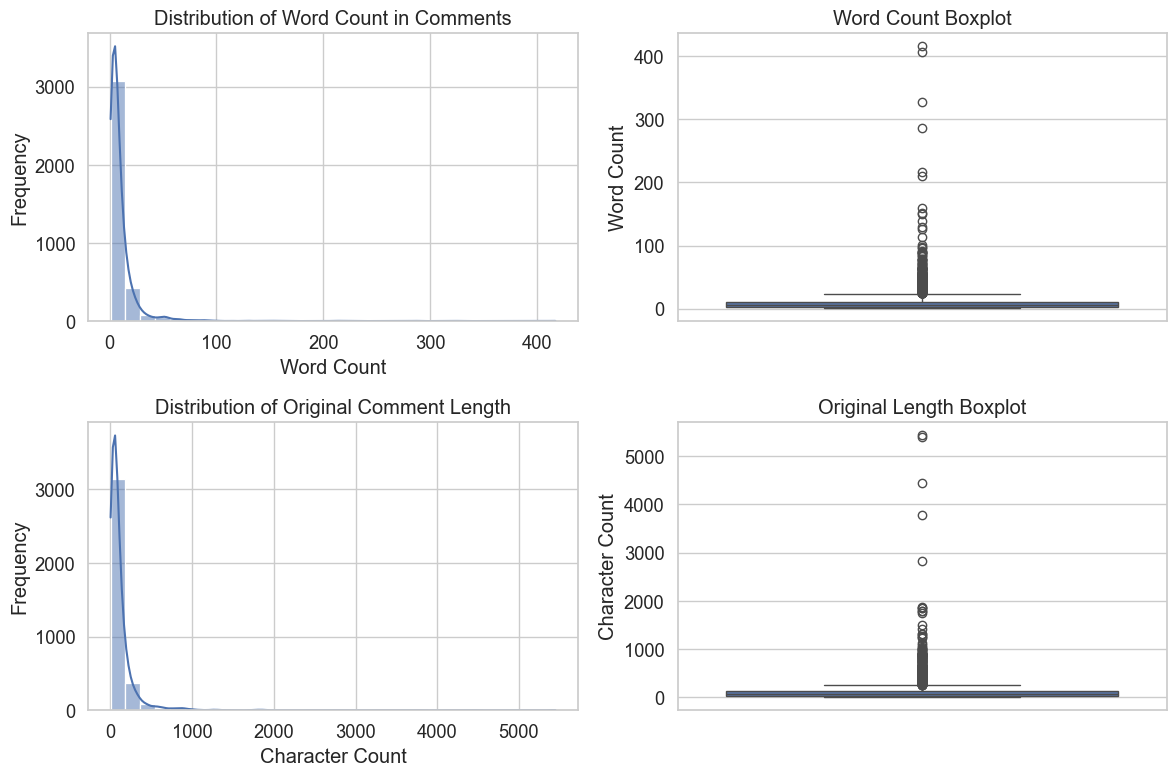

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(df_comments['word_count'], kde=True, bins=30)
plt.title('Distribution of Word Count in Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.boxplot(y=df_comments['word_count'])
plt.title('Word Count Boxplot')
plt.ylabel('Word Count')

plt.subplot(2, 2, 3)
sns.histplot(df_comments['original_length'], kde=True, bins=30)
plt.title('Distribution of Original Comment Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.boxplot(y=df_comments['original_length'])
plt.title('Original Length Boxplot')
plt.ylabel('Character Count')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "comment_length_distribution.png"))
plt.show()

#### Cell 2: Outlier Detection
Mendeteksi dan menampilkan komentar yang dianggap outlier berdasarkan jumlah kata.

In [ ]:
display(Markdown("### Outlier Detection"))
Q1 = df_comments['word_count'].quantile(0.25)
Q3 = df_comments['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_comments[(df_comments['word_count'] < lower_bound) | (df_comments['word_count'] > upper_bound)]
print(f"Detected {len(outliers)} outliers in word count ({len(outliers)/len(df_comments)*100:.2f}% of data)")

if len(outliers) > 0:
    display(Markdown("#### Examples of Outlier Comments:"))
    display(outliers.sort_values('word_count', ascending=False)[['text', 'word_count']].head())

### Outlier Detection

Detected 271 outliers in word count (7.35% of data)


#### Examples of Outlier Comments:

,text,word_count
2570,- (12:00) : Sudah sekian tahun kita merdeka. Tapi masih ngomongin masalah makanan bergizi dan pe...,417
1869,"“Pak Prabowo Menjawab ❌❌❌”\n“Pak Prabowo Membantah ✅✅✅”\n\nAwal kemunculan video ini, jujur gw l...",407
1794,Ringkasan\r\n\r\nDiskusi dimulai dengan dialek informal antara Presiden Prabowo Subianto dan par...,327
3755,"RINGKASAN AI (Kemungkinan tidak 100% sesuai pembicaranya, ini untuk sekedar baca untuk tau kira2...",286
3177,Timestamp -- Silahkan klik tanda waktu ke topik yang lo paling pengen tahu. \n\n01:30 Pemaparan ...,216


#### Cell 3: Publication Time Analysis
Menganalisis waktu publikasi komentar berdasarkan tanggal dan jam, serta menampilkan grafik distribusinya.

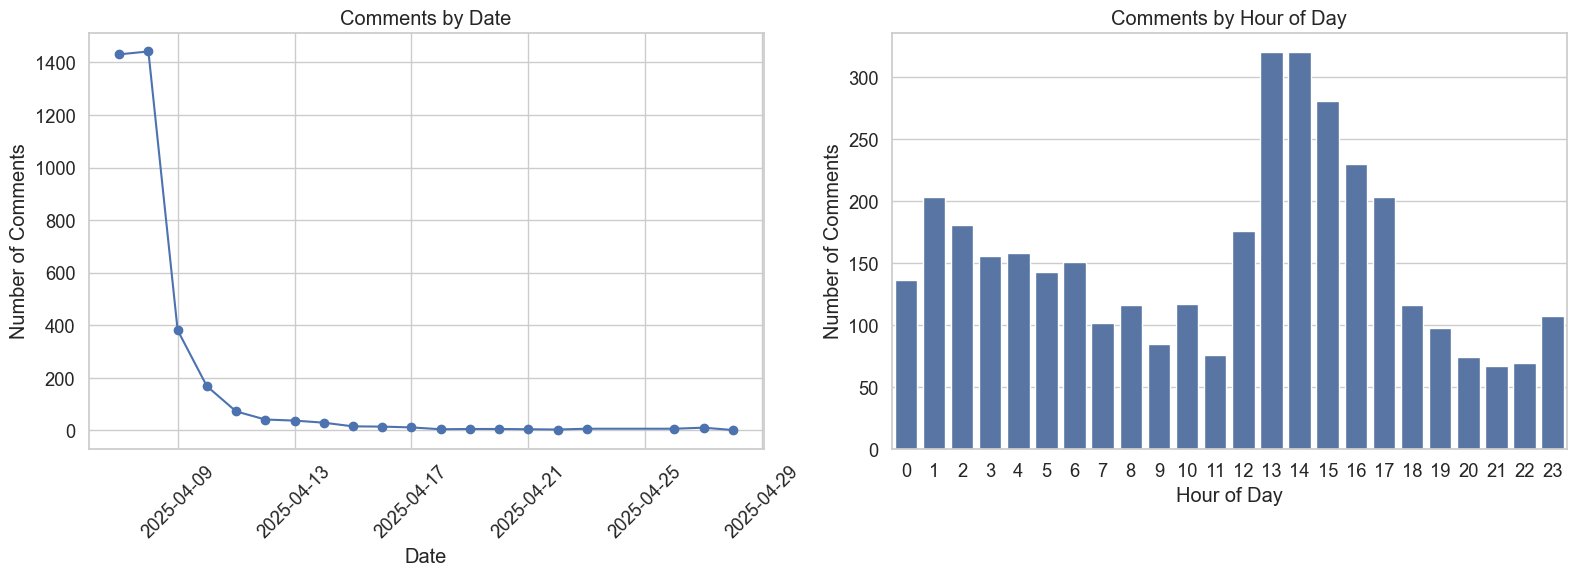

In [ ]:
df_comments['published_at'] = pd.to_datetime(df_comments['published_at'])
df_comments['publication_date'] = df_comments['published_at'].dt.date
df_comments['publication_hour'] = df_comments['published_at'].dt.hour

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
date_counts = df_comments['publication_date'].value_counts().sort_index()
date_counts.plot(kind='line', marker='o')
plt.title('Comments by Date')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
hour_counts = df_comments['publication_hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Comments by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Comments')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "comment_publication_time.png"))
plt.show()

#### Cell 4: Like Count Analysis
Menampilkan distribusi dan boxplot dari jumlah like pada komentar.

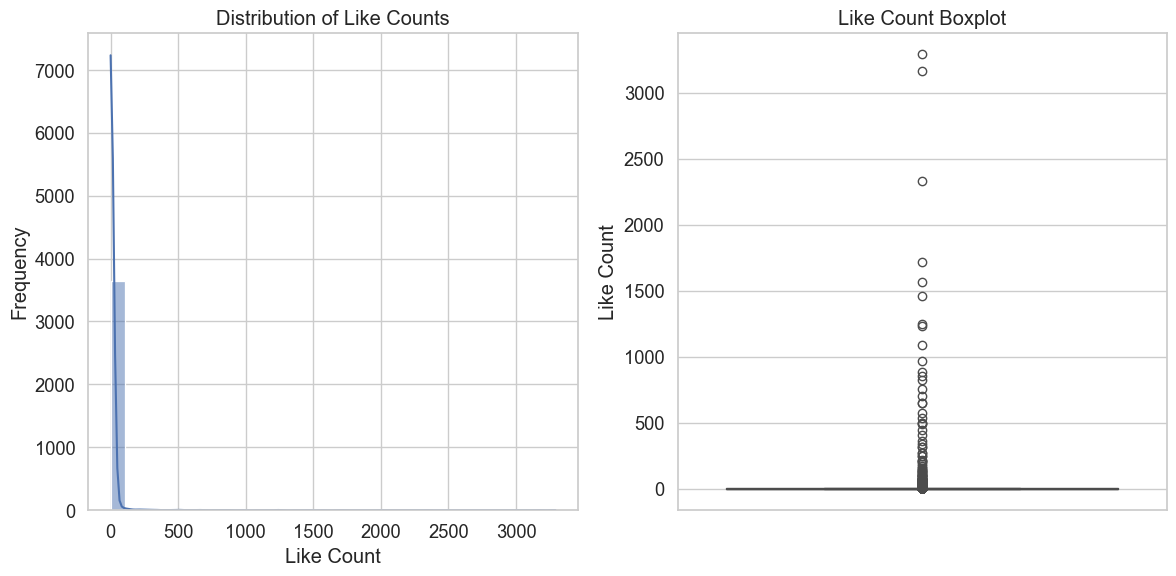

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_comments['like_count'], bins=30, kde=True)
plt.title('Distribution of Like Counts')
plt.xlabel('Like Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_comments['like_count'])
plt.title('Like Count Boxplot')
plt.ylabel('Like Count')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "like_count_distribution.png"))
plt.show()

#### Cell 5: Top Liked Comments
Menampilkan 5 komentar dengan jumlah like terbanyak.

In [ ]:
display(Markdown("### Top 5 Most Liked Comments"))
top_liked = df_comments.sort_values('like_count', ascending=False).head(5)[['text', 'like_count', 'author']]
display(top_liked)

### Top 5 Most Liked Comments

,text,like_count,author
3707,"1:30:02 mba Nana ngotot karena tahu jawaban Prabowo ngelantur, nanya kekhawatiran abuse of power...",3291,@JokoJMC
3177,Timestamp -- Silahkan klik tanda waktu ke topik yang lo paling pengen tahu. \n\n01:30 Pemaparan ...,3161,@FellexandroRuby
1608,Satu hal yang terjawab: ternyata problematikanya bukan hanya di orang-orang sekitar Presiden. Ta...,2334,@rizkyaja.3810
3743,"judul seharusnya ""Presiden Prabowo Tidak Menjawab""",1715,@xoxouwuwww
3623,Presiden Prabowo Menjawab ❌\nPresiden Prabowo Membantah ✔️,1564,@phantom6952


#### Cell 6: Word Frequency Analysis
Menganalisis dan menampilkan 20 kata yang paling sering muncul dalam komentar.

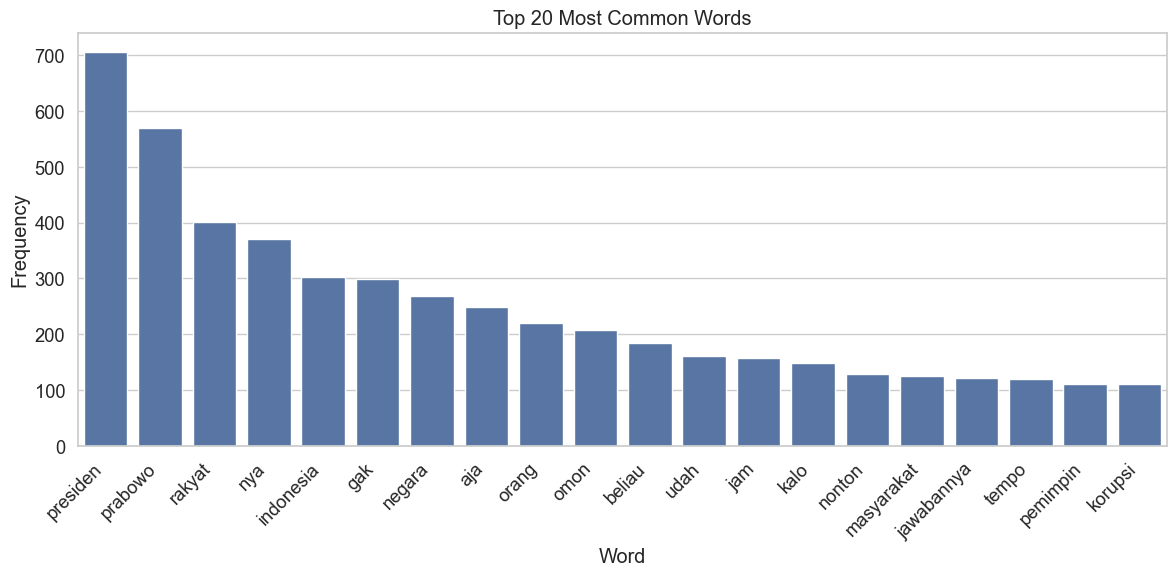

In [ ]:
all_words = ' '.join(df_comments['cleaned_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "common_words.png"))
plt.show()

#### Cell 7: Word Cloud Visualization
Menampilkan visualisasi word cloud dari komentar yang telah dibersihkan.


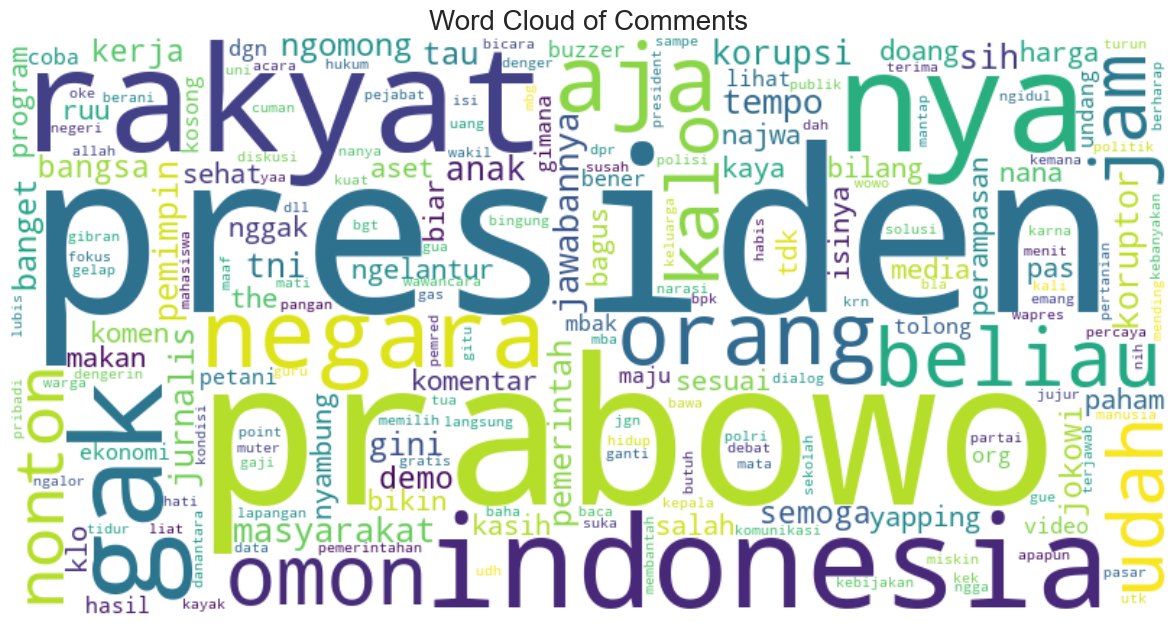

In [ ]:
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    stopwords=stop_words, 
    max_words=200,
    collocations=False
).generate(' '.join(df_comments['cleaned_text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "wordcloud.png"))
plt.show()

#### Cell 8: Correlation Analysis
Menganalisis dan menampilkan matriks korelasi antara fitur numerik yang ada dalam komentar.


### Correlation Analysis

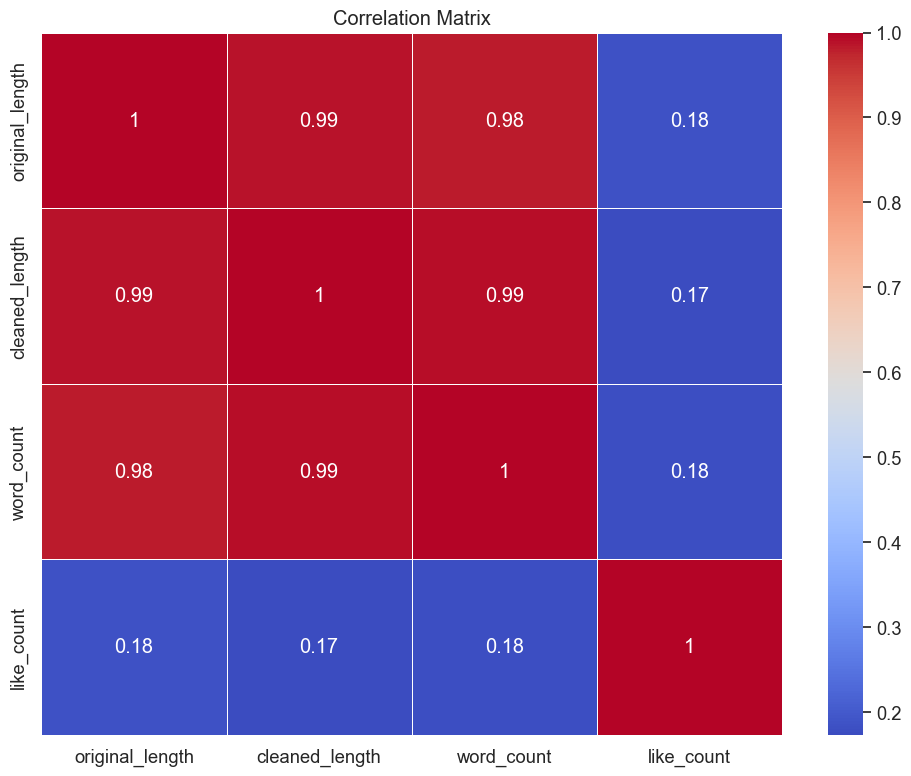

In [ ]:
display(Markdown("### Correlation Analysis"))
numeric_df = df_comments[['original_length', 'cleaned_length', 'word_count', 'like_count']]
correlation = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "correlation_matrix.png"))
plt.show()

#### Cell 9: Summary EDA Report
Menyajikan ringkasan statistik dan temuan utama dari analisis eksplorasi data (EDA) yang dilakukan.

In [ ]:
display(Markdown("### Summary EDA Report"))
eda_summary = {
    "Total Comments": len(df_comments),
    "Average Word Count": df_comments['word_count'].mean(),
    "Median Word Count": df_comments['word_count'].median(),
    "Maximum Word Count": df_comments['word_count'].max(),
    "Average Like Count": df_comments['like_count'].mean(),
    "Total Likes": df_comments['like_count'].sum(),
    "Most Common Words": [word[0] for word in common_words[:10]],
    "Outlier Comments": len(outliers),
    "Most Active Date": date_counts.idxmax(),
    "Most Active Hour": hour_counts.idxmax()
}

for key, value in eda_summary.items():
    print(f"📊 {key}: {value}")

### Summary EDA Report

📊 Total Comments: 3685
📊 Average Word Count: 9.886567164179105
📊 Median Word Count: 6.0
📊 Maximum Word Count: 417
📊 Average Like Count: 10.319402985074626
📊 Total Likes: 38027
📊 Most Common Words: ['presiden', 'prabowo', 'rakyat', 'nya', 'indonesia', 'gak', 'negara', 'aja', 'orang', 'omon']
📊 Outlier Comments: 271
📊 Most Active Date: 2025-04-08
📊 Most Active Hour: 13


### Text Clustering Analysis

#### cell 1: Membuat TF-IDF 
Membuat representasi TF-IDF untuk teks komentar yang sudah dibersihkan.


In [ ]:
print("🔄 Performing text clustering to identify main topics...")

stop_words = list(stop_words)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000  ,
    min_df=5,
    max_df=0.7,
    stop_words=stop_words
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_comments['cleaned_text'])
print(f"✅ Created TF-IDF matrix with shape: {tfidf_matrix.shape}")

🔄 Performing text clustering to identify main topics...
✅ Created TF-IDF matrix with shape: (3685, 1252)


#### Cell 2: Menentukan Jumlah Cluster Optimal (Elbow Method)
Menentukan jumlah cluster optimal dengan Elbow Method berdasarkan inertia.


Finding optimal clusters:   0%|          | 0/10 [00:00<?, ?it/s]

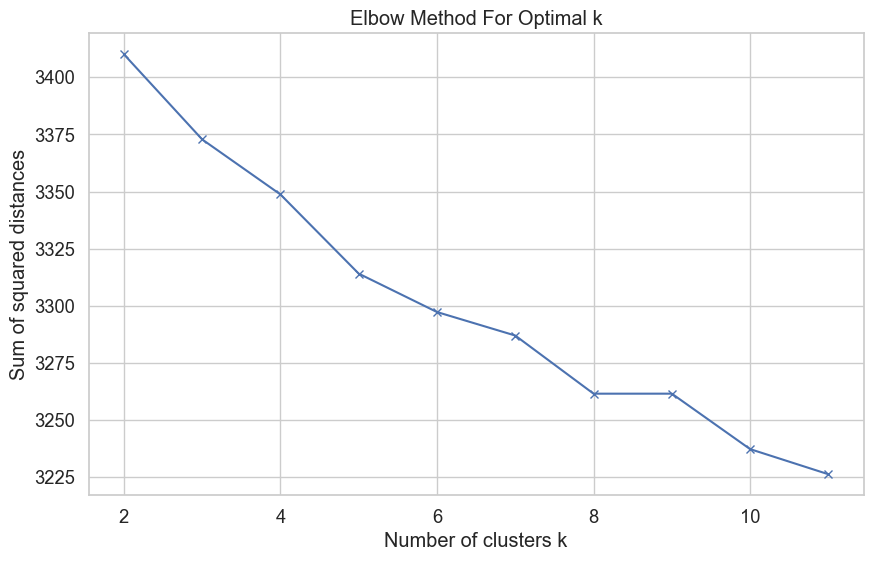

In [ ]:
sum_of_squared_distances = []
K_range = range(2, 12)

for k in tqdm(K_range, desc="Finding optimal clusters"):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km = km.fit(tfidf_matrix)
    sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.savefig(os.path.join(output_dir, "elbow_method.png"))
plt.show()

#### Cell 3: Menerapkan KMeans dan Menambahkan Informasi Cluster
Melakukan KMeans clustering dengan jumlah cluster optimal dan menambahkan hasilnya ke dataframe.


In [ ]:
optimal_k = 3
print(f"🔍 Selected {optimal_k} as the optimal number of clusters")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_matrix)

df_comments['cluster'] = clusters

🔍 Selected 5 as the optimal number of clusters


#### Cell 4: Menampilkan Top Terms di Setiap Cluster
Menampilkan daftar kata-kata paling penting di setiap cluster.

In [ ]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

display(Markdown("### Top Terms in Each Cluster"))
for i in range(optimal_k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

### Top Terms in Each Cluster

Cluster 0: prabowo, nya, rakyat, gak, jam, nonton, aja, indonesia, orang, udah
Cluster 1: tempo, diundang, gak, jurnalis, metro, undang, diajak, ajak, media, ngga
Cluster 2: beliau, ngomong, prabowo, gak, presiden, sih, paham, tau, indonesia, aja
Cluster 3: omon, presiden, doang, real, nya, cuman, dengerin, jam, aja, gak
Cluster 4: presiden, prabowo, indonesia, gini, rakyat, aja, negara, gak, sehat, nya


#### Cell 5: Visualisasi Distribusi Komentar di Tiap Cluster
Membuat plot distribusi jumlah komentar pada masing-masing cluster.

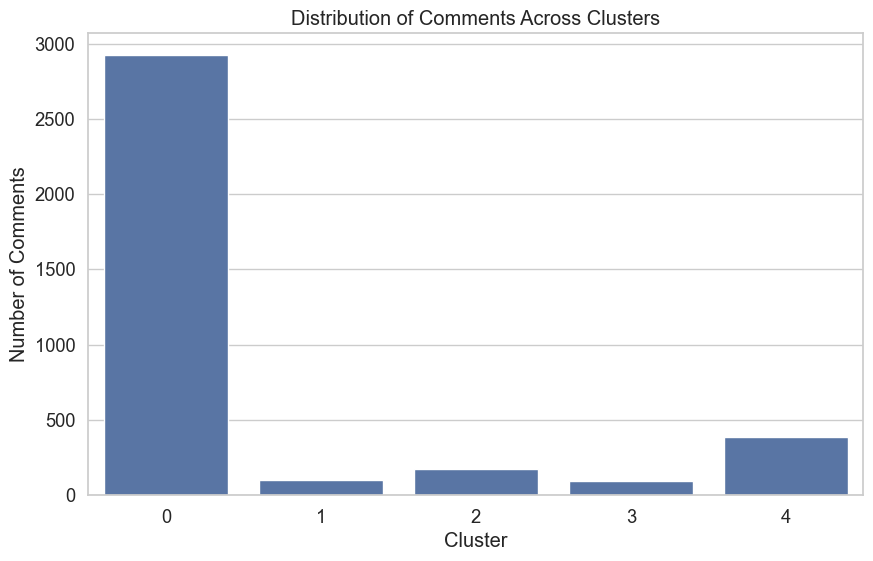

In [ ]:
plt.figure(figsize=(10, 6))
cluster_counts = df_comments['cluster'].value_counts().sort_index()
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Distribution of Comments Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Comments')
plt.xticks(range(optimal_k))
plt.grid(True, axis='y')
plt.savefig(os.path.join(output_dir, "cluster_distribution.png"))
plt.show()

#### Cell 6: Menampilkan Contoh Komentar dari Setiap Cluster
Menampilkan beberapa contoh komentar dengan like terbanyak dari setiap cluster.

In [ ]:
display(Markdown("### Sample Comments from Each Cluster"))
for cluster_id in range(optimal_k):
    cluster_comments = df_comments[df_comments['cluster'] == cluster_id]
    display(Markdown(f"#### Cluster {cluster_id} (contains {len(cluster_comments)} comments)"))
    sample_comments = cluster_comments.sort_values('like_count', ascending=False).head(3)
    
    for _, row in sample_comments.iterrows():
        print(f"👤 {row['author']}: \"{row['text']}\" (Likes: {row['like_count']})")
    print()


### Sample Comments from Each Cluster

#### Cluster 0 (contains 2922 comments)

👤 @JokoJMC: "1:30:02 mba Nana ngotot karena tahu jawaban Prabowo ngelantur, nanya kekhawatiran abuse of power TNI malah dijawab penambahan usia pensiun, nanya transparansi malah dijawab sudah berjalan belasan tahun, nanya rakyat tidak mendapatkan akses malah dijawab naskah yang beredar palsu" (Likes: 3291)
👤 @teamshare7558: "Saya salut dengan konsisten Pak Prabowo, konsistensi gak ngerti masalah bangsa.. modal gemuk dan teriak doang 😅" (Likes: 1456)
👤 @Bakul_tempe_brebes: "Dari sini gw tau mereka jurnalis yg hebat,

Karna bisa mendengarkan hal yang ngelantur tanpa mencela" (Likes: 1244)



#### Cluster 1 (contains 104 comments)

👤 @Redism-i: "Tempo ga diajak nih??? hemm" (Likes: 64)
👤 @aryaexplorer: "Kalo mmg berani terbuka undang Tempo juga dong. Selain Tempo semua media sdh dipertanyakan kredibilitasnya" (Likes: 43)
👤 @sanileonardo444: "JURNALIS TEMPO SAMA METRO TV KEMANA? KOK GAK ADA DI AJAK?" (Likes: 24)



#### Cluster 2 (contains 176 comments)

👤 @SofelRose1: "Wahai penonton yg kesal, what do you expect? Dari debat capres kemarin2 kan sudah terlihat kualitas menjawab pertanyaan beliau. Jangan berharap seseorang diumur dan ego level seperti beliau bisa berubah guys, itu sudah jadi karakter. 

Dari awal menonton sy berharap mendapat jawaban dr keresahan, sampai akhir sy malah sakit kepala menahan emosi karna tdk ada yg nyambung 😭🙏🏻 

Well Indonesia sudah tidak ada harapan lagi ketika president nya mengatakan tidak semua hal tanggung jawab dia. Ketika pemimpin punya mindset seperti itu maka bawah2nya pun seperti itu." (Likes: 854)
👤 @astrobois2883: "Pak Prabowo dari awal debat capres juga jawabannya udah ngelantur ngalor ngidul ga nyambung, terus sekarang setelah terpilih kita berekspektasi komunikasi beliau jadi bagus? Come on... Nonsense...." (Likes: 820)
👤 @ilhamjanuar5510: "Sebenarnya kualitas beliau dan pasangannya sudah terlihat sejak awal pilpres, mulai dari selalu menghindar ketika diajak diskusi dan debat ilmiah dgn mah

#### Cluster 3 (contains 94 comments)

👤 @hafidzrasyid5409: ""ingat umur pak...jangan ikut2 Pinokio jadi pengibul... Cuman omon omon" (Likes: 74)
👤 @doaibu475: "Omon2😂" (Likes: 20)
👤 @hello_Aii: "baru menit ke 5 sudah khawatir isinya omon omon dan pembelaan doang, padahal durasinya 3½ jam 😮‍💨" (Likes: 16)



#### Cluster 4 (contains 389 comments)

👤 @FellexandroRuby: "Timestamp -- Silahkan klik tanda waktu ke topik yang lo paling pengen tahu. 

01:30 Pemaparan Presiden soal capaian 150 hari.
14:20 "Kita punya inflasi salah satu terendah. Rasio utang salah satu terendah" 
26:50 Alfito (Pemred Detikcom) -- "Kenapa memilih tidak membangun monumen? Kenapa ke hal basic seperti swasembada?" 
37:10 Alfito (Pemred Detikcom) -- Pertanyaan seputar komunikasi publik kantor kepresidenan yang kurang baik. Isu "Dimasak aja (kepala babi)"
48:38 Uni Lubis (Pemred IDN Times) -- "Bagaimana penanganan aparat yang abusive? Apa urgensinya UU TNI dibahas begitu cepat?" 
56:58 Jawaban Presiden seputar RUU TNI : "Bagaimana kita bisa punya organisasi yang pemimpinnya ganti tiap tahun. Inti RUU ini hanya memperpanjang usia pensiun. Ga ada niat TNI mau dwifungsi lagi. Come on. Nonsense." 
1:00:00 Uni Lubis (Pemred IDN Times) -- Pertanyaan seputar transparansi pembahasan RUU TNI
1:01:33 Jawaban Presiden -- "Yang bawa TNI kembali ke barak itu siapa? Pemimpi

#### Cell 7: Menyimpan Hasil Clustering ke File CSV
Menyimpan hasil clustering komentar ke dalam file CSV.


In [ ]:
df_comments[['text', 'author', 'like_count', 'cluster']].to_csv(
    os.path.join(output_dir, "clustered_comments.csv"), 
    index=False
)
print(f"💾 Clustering results saved to {os.path.join(output_dir, 'clustered_comments.csv')}")

💾 Clustering results saved to ./output/clustered_comments.csv


#### Cell 8: Visualisasi Clustering dengan PCA
Membuat visualisasi sebaran komentar berdasarkan hasil clustering menggunakan PCA.

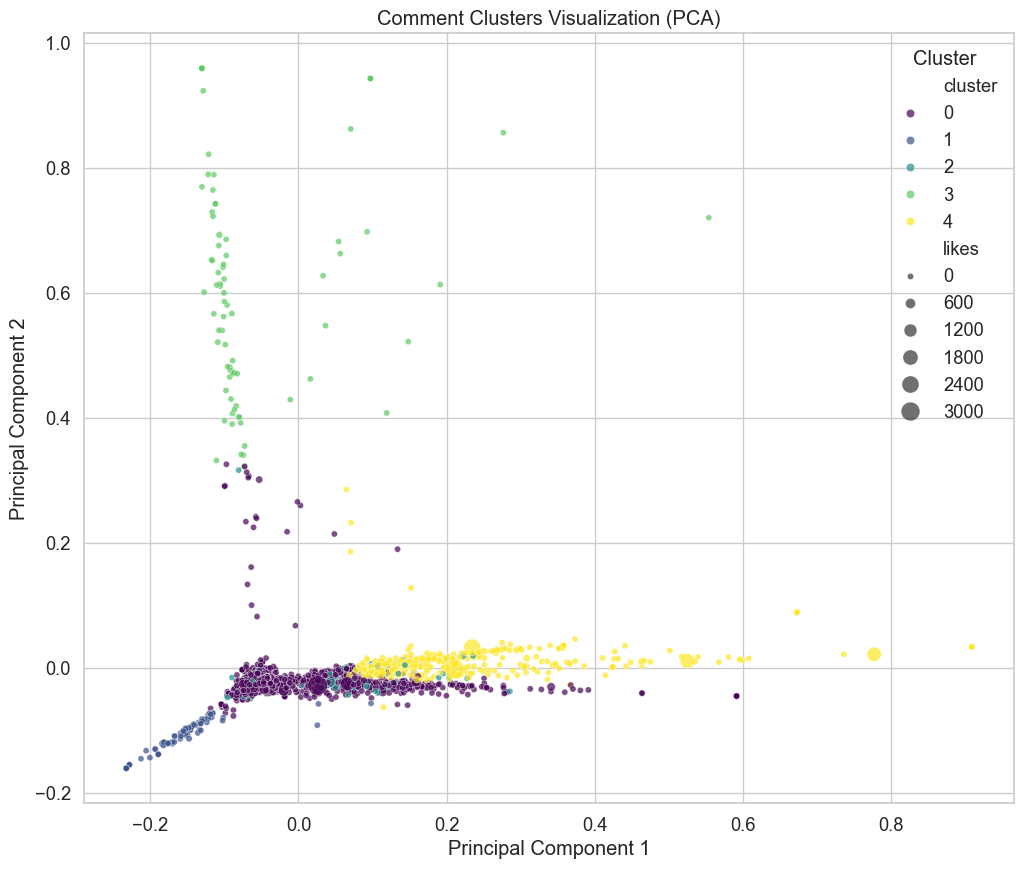

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())

vis_df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'cluster': clusters,
    'likes': df_comments['like_count'],
    'text': df_comments['text']
})

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=vis_df,
    x='x', 
    y='y',
    hue='cluster',
    palette='viridis',
    size='likes',
    sizes=(20, 200),
    alpha=0.7
)
plt.title('Comment Clusters Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.savefig(os.path.join(output_dir, "cluster_visualization.png"))
plt.show()


### Sentiment Analysis with Gemini API

#### Cell 1: Sampling Data untuk Analisis Sentimen
Sampling sebagian komentar untuk dianalisis sentimennya menggunakan Gemini API.


In [ ]:
sample_size = len(df_comments)
comments_sample = df_comments

print(f"🔄 Analyzing sentiment for {sample_size} comments...")

🔄 Analyzing sentiment for 3685 comments...


#### Cell 2: Definisi Fungsi Analisis Sentimen dengan Gemini
Mendefinisikan fungsi untuk mengirim komentar ke Gemini API dan mengambil hasil sentimen serta rekomendasi.


In [ ]:
def analyze_sentiment_with_gemini(comment, model):
    prompt = f"""
    Berikut ini adalah komentar terhadap video "Prabowo Menjawab".

    Tugas Anda adalah:
    1. Analisis sentimen komentar berikut dalam bahasa Indonesia.
    2. Klasifikasikan sentimen sebagai 'Positif', 'Negatif', atau 'Netral'.
    3. Jelaskan alasan di balik klasifikasi sentimen tersebut.
    4. Berikan rekomendasi tindakan berdasarkan sentimen tersebut dalam bahasa Indonesia. Misalnya:
       - Jika sentimen Positif, berikan saran untuk mendorong lebih banyak interaksi positif.
       - Jika sentimen Negatif, beri saran untuk memperbaiki atau merespons keluhan.
       - Jika sentimen Netral, beri saran untuk menjaga keseimbangan dan mencari kesempatan untuk merespons.

    Komentar:
    "{comment}"

    **Gunakan format jawaban ini saja, tanpa tambahan apapun:**
    Sentimen: [Positif/Negatif/Netral]
    Alasan: [Alasan klasifikasi sentimen]
    Rekomendasi: [rekomendasi tindakan dalam bahasa Indonesia]
    """
    
    try:
        response = model.generate_content(prompt)
        text = response.text
        
        sentiment_match = re.search(r'Sentimen: (.*)', text)
        reason_match = re.search(r'Alasan: (.*)', text)
        recommendation_match = re.search(r'Rekomendasi: (.*)', text)
        
        sentiment = sentiment_match.group(1).strip() if sentiment_match else "Tidak Diketahui"
        reason = reason_match.group(1).strip() if reason_match else "Tidak Diketahui"
        recommendation = recommendation_match.group(1).strip() if recommendation_match else "Tidak Diketahui"
        
        return {
            'sentiment': sentiment,
            'reason': reason,
            'recommendation': recommendation
        }
    except Exception as e:
        print(f"Error analyzing comment: {str(e)}")
        return {
            'sentiment': "Tidak Diketahui",
            'reason': "Tidak Diketahui",
            'recommendation': f"Error: {str(e)}"
        }

#### Cell 3: Proses Analisis Sentimen
Melakukan analisis sentimen pada setiap komentar dengan Gemini dan menyimpan hasilnya.


In [ ]:
model_index = 0
results = []
for i, (_, row) in enumerate(tqdm(list(comments_sample.iterrows()), desc="Gemini Sentiment Analysis")):
    retry_count = 0
    while retry_count < 5: 
        try:
            result = analyze_sentiment_with_gemini(row['text'], gemini_model)
            results.append({
                'comment_id': row.get('comment_id', i),
                'text': row['text'],
                'author': row['author'],
                'like_count': row['like_count'],
                'sentiment': result['sentiment'],
                'recommendation': result['recommendation']
            })
            break
        except Exception as e:
            if '429' in str(e):
                retry_count += 1
                print(f"Rate limit exceeded, retrying... ({retry_count}/5)")
                time.sleep(60)
            else:
                print(f"Error analyzing comment: {e}")
                break  #

    if (i + 1) % 15 == 0:
        print("🔄 15 comments processed, waiting for 80 seconds...")
        time.sleep(80)

Gemini Sentiment Analysis:   0%|          | 0/1250 [00:00<?, ?it/s]

🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waiting for 80 seconds...
🔄 15 comments processed, waitin

#### Cell 4: Menyimpan dan Menampilkan Hasil Analisis Sentimen
Menyimpan hasil analisis sentimen ke file CSV dan menampilkan sampel hasil analisis.

In [ ]:
df_sentiment = pd.DataFrame(results)

df_sentiment_clean = df_sentiment[
    (df_sentiment['sentiment'] != "Tidak Diketahui") &
    (~df_sentiment['recommendation'].str.startswith("Error"))
].reset_index(drop=True)

display(Markdown("### Sample of Cleaned Sentiment Analysis Results"))
display(df_sentiment_clean[['text', 'sentiment', 'recommendation']].head())

# 💾 Save clean
sentiment_path = os.path.join(output_dir, "sentiment_analysis.csv")
df_sentiment_clean.to_csv(sentiment_path, index=False)

print(f"💾 Sentiment analysis results saved to {sentiment_path}")


### Sample of Cleaned Sentiment Analysis Results

,text,sentiment,recommendation
0,kenapa ada nama jokowi sih???,Negatif,Mengabaikan komentar tersebut karena cenderung provokatif dan tidak membangun. Fokus pada koment...
1,Dengan video ini Banyak buzzer bekerja,Negatif,"Pantau aktivitas yang dianggap buzzer, lakukan klarifikasi jika ada informasi yang tidak akurat ..."
2,masih kampanye rupanya,Netral,Tidak ada tindakan spesifik diperlukan. Komentar ini merupakan observasi dan tidak memerlukan re...
3,MetroTV sma Tempo kok tdk di undang?,Netral,Perlu ditelusuri alasan MetroTV dan Tempo tidak diundang dan mempertimbangkan untuk mengundang m...
4,1:13:40 bagus bapak kalau mau negosiasi tapi masalahnya trump batasin waktu sampai 9 april kenap...,Negatif,Tim komunikasi Prabowo perlu memberikan klarifikasi mengenai perbedaan waktu negosiasi yang dise...


💾 Sentiment analysis results saved to ./output/sentiment_analysis.csv


#### Cell 5: Menghitung dan Menampilkan Distribusi Sentimen
Menghitung jumlah dan persentase masing-masing kategori sentimen.

In [ ]:
sentiment_counts = df_sentiment['sentiment'].value_counts()

print("\n📊 Sentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df_sentiment)) * 100
    print(f"{sentiment}: {count} comments ({percentage:.1f}%)")


📊 Sentiment Distribution:
Negatif: 773 comments (61.8%)
Netral: 267 comments (21.4%)
Positif: 210 comments (16.8%)


#### Cell 6: Visualisasi Distribusi Sentimen (Bar Chart)
Membuat bar chart untuk menampilkan distribusi jumlah komentar per kategori sentimen.

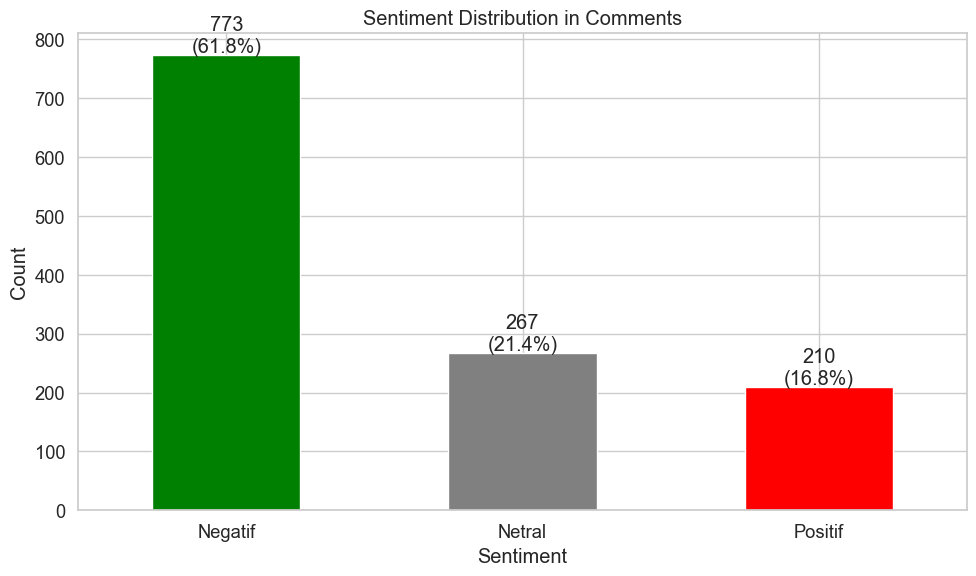

In [ ]:
plt.figure(figsize=(10, 6))
ax = sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution in Comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

for i, v in enumerate(sentiment_counts):
    percentage = (v / len(df_sentiment)) * 100
    ax.text(i, v + 5, f"{v}\n({percentage:.1f}%)", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sentiment_distribution.png"))
plt.show()


#### Cell 7: Visualisasi Distribusi Sentimen (Pie Chart)
Membuat pie chart untuk menampilkan persentase distribusi sentimen.

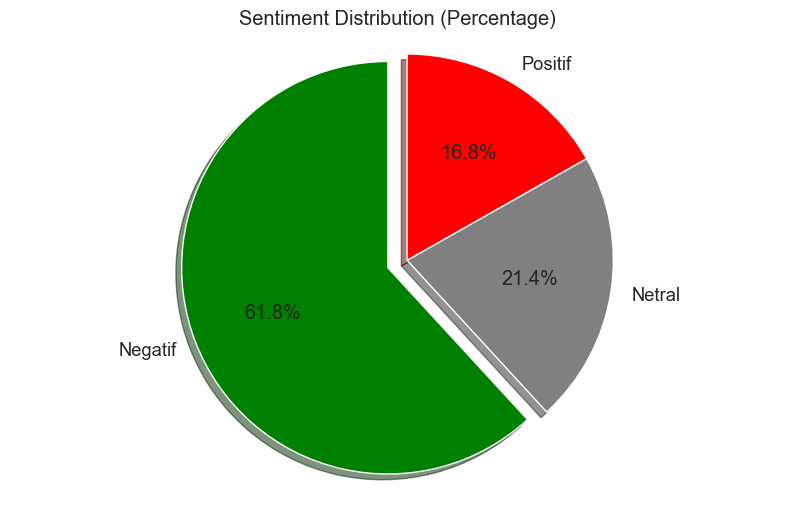

In [ ]:
# Membuat pie chart distribusi sentimen
plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    autopct='%1.1f%%', 
    colors=['green', 'gray', 'red'],
    explode=[0.1 if s == sentiment_counts.index[0] else 0 for s in sentiment_counts.index],
    shadow=True,
    startangle=90
)
plt.title('Sentiment Distribution (Percentage)')
plt.axis('equal')
plt.savefig(os.path.join(output_dir, "sentiment_pie_chart.png"))
plt.show()

#### Cell 8: Generate Ringkasan dari Hasil Analisis Sentimen
Membuat ringkasan otomatis dari hasil analisis sentimen menggunakan Gemini API.

In [ ]:
def generate_summary_with_gemini(sentiment_df, model):
    counts = sentiment_df['sentiment'].value_counts()
    sentiment_summary = ", ".join([f"{s}: {c} ({c/len(sentiment_df)*100:.1f}%)" for s, c in counts.items()])
    
    prompt = f"""
    Anda diminta untuk membuat ringkasan analisis sentimen dari {len(sentiment_df)} komentar YouTube terhadap video "Prabowo Menjawab" dalam bahasa Indonesia.

    Distribusi sentimen:
    {sentiment_summary}
    
    Contoh komentar positif:
    {sentiment_df[sentiment_df['sentiment'] == 'Positif']['text'].sample(10).tolist()}
    
    Contoh komentar negatif:
    {sentiment_df[sentiment_df['sentiment'] == 'Negatif']['text'].sample(10).tolist() if 'Negatif' in counts else []}
    
    Contoh komentar netral:
    {sentiment_df[sentiment_df['sentiment'] == 'Netral']['text'].sample(10).tolist() if 'Netral' in counts else []}

    Buatlah ringkasan analisis dalam 3-5 paragraf yang mencakup:
    1. Gambaran umum sentimen penonton terhadap Prabowo berdasarkan komentar.
    2. Tema atau topik utama yang muncul dalam komentar positif.
    3. Tema atau topik utama yang muncul dalam komentar negatif (jika ada).
    4. Insight atau rekomendasi tindakan yang dapat diambil berdasarkan hasil analisis sentimen.
    5. Rekomendasi perbaikan untuk meningkatkan persepsi positif di masa depan, berdasarkan komentar negatif dan netral.

    **Tulis ringkasan dengan bahasa yang formal, objektif, dan hindari opini pribadi.**
    """

    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Error generating summary: {str(e)}"

print("\n🔄 Generating sentiment analysis summary...")
summary = generate_summary_with_gemini(df_sentiment, gemini_model)


🔄 Generating sentiment analysis summary...


#### Cell 9: Menyimpan dan Menampilkan Ringkasan Analisis Sentimen
Menyimpan ringkasan analisis sentimen ke file dan menampilkannya di notebook.


In [ ]:
display(Markdown("### Sentiment Analysis Summary"))
display(Markdown(summary))

with open(os.path.join(output_dir, "sentiment_summary.md"), "w") as f:
    f.write(summary)

print(f"💾 Sentiment summary saved to {os.path.join(output_dir, 'sentiment_summary.md')}")

### Sentiment Analysis Summary

Berikut ringkasan analisis sentimen dari 1250 komentar YouTube pada video "Prabowo Menjawab":

Analisis sentimen menunjukkan bahwa mayoritas komentar bersifat negatif (61.8%), diikuti oleh komentar netral (21.4%) dan positif (16.8%). Distribusi ini mengindikasikan adanya kecenderungan sentimen negatif yang signifikan terhadap konten video tersebut, yang perlu dipertimbangkan dalam evaluasi respons publik terhadap Prabowo.

Komentar positif cenderung menyoroti ketulusan Prabowo dalam membangun negara dan memimpin bangsa, serta apresiasi terhadap detail jawaban yang diberikan dalam wawancara. Beberapa komentar juga menunjukkan dukungan terhadap kebijakan dan tindakan yang diambil sejak menjabat sebagai presiden. Harapan akan kepemimpinan yang baik dan mampu membawa kemakmuran bagi Indonesia juga menjadi tema yang menonjol dalam komentar positif.

Sebaliknya, komentar negatif mencerminkan kekecewaan terhadap narasi yang disampaikan dalam video, kesulitan dalam memahami jawaban yang diberikan (tidak to the point), dan dugaan adanya settingan atau keberpihakan dalam pemilihan narasumber. Kritik juga ditujukan pada perubahan gaya kepemimpinan Prabowo dibandingkan saat masih menjadi calon presiden. Beberapa komentar bahkan menyuarakan penyesalan dan harapan akan adanya pemilu ulang.

Berdasarkan hasil analisis sentimen, disarankan untuk meningkatkan transparansi dan kejelasan komunikasi publik terkait kebijakan dan tindakan pemerintah. Lebih jauh lagi, sangat penting untuk memastikan bahwa semua lapisan masyarakat merasa terwakili dan didengarkan, terlepas dari posisi politiknya, sebagai langkah penting untuk meningkatkan kepercayaan publik. Dengan langkah ini, pemerintahan Prabowo dapat memperkuat dukungan publik dan menciptakan lingkungan yang lebih konstruktif untuk diskusi dan pembangunan nasional.

Untuk meningkatkan persepsi positif di masa depan, disarankan untuk: (1) Meningkatkan transparansi dan akuntabilitas dalam pengambilan kebijakan. (2) Memastikan komunikasi publik yang lebih jelas dan lugas agar mudah dipahami oleh semua kalangan masyarakat. (3) Meningkatkan keterlibatan publik dalam proses pengambilan keputusan, termasuk mendengarkan kritik dan masukan dari berbagai pihak. (4) Memperbaiki citra kepemimpinan dengan menunjukkan konsistensi antara janji kampanye dan tindakan nyata. (5) Menjaga independensi media dan menghindari persepsi keberpihakan dalam pemilihan narasumber atau topik yang dibahas. Langkah-langkah ini diharapkan dapat mengurangi sentimen negatif dan membangun kepercayaan publik terhadap Prabowo dan pemerintahannya.


💾 Sentiment summary saved to ./output/sentiment_summary.md


### Transformer Models Comparison for Sentiment Analysis

#### Cell 1: Setup Data & Label Mapping
Menyiapkan data dan memetakan label sentimen menjadi format numerik untuk klasifikasi.

In [ ]:
print("🔄 Setting up transformer models for comparison...")

SENTIMENT_MAP = {
    'Positif': 2,
    'Netral': 1,
    'Negatif': 0,
    'Tidak Diketahui': 1
}

labeled_data = df_sentiment.copy()
labeled_data['sentiment_label'] = labeled_data['sentiment'].map(SENTIMENT_MAP)

🔄 Setting up transformer models for comparison...


#### Cell 2: Split Data Train/Test
Membagi data menjadi set pelatihan dan pengujian.

In [ ]:
X = labeled_data['text'].values
y = labeled_data['sentiment_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"✅ Prepared training dataset with {len(X_train)} samples and test dataset with {len(X_test)} samples")

✅ Prepared training dataset with 875 samples and test dataset with 375 samples


#### Cell 3: Definisikan Fungsi Evaluasi dan Plotting
Mendefinisikan fungsi untuk evaluasi model dan visualisasi confusion matrix.

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_{model_name.lower().replace(' ', '_')}.png"))
    plt.show()

sentiment_classes = ['Negatif', 'Netral', 'Positif']
model_results = []

#### Cell 4: Setup dan Evaluasi BERT
Melakukan prediksi dan evaluasi menggunakan model BERT.


🔄 Setting up fine-tuned BERT model...


Device set to use cpu


BERT Predictions:   0%|          | 0/375 [00:00<?, ?it/s]

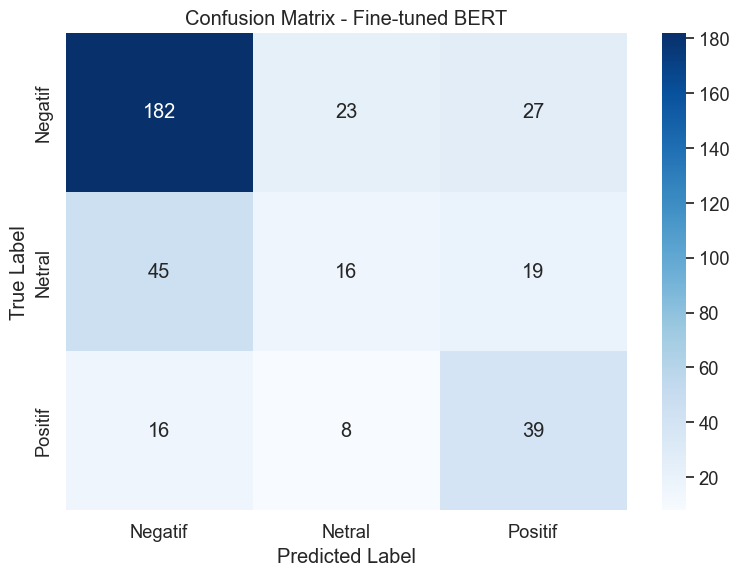

✅ Fine-tuned BERT model evaluation complete. Accuracy: 0.6320


In [ ]:
print("\n🔄 Setting up fine-tuned BERT model...")

try:
    bert_model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
    bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
    bert_classifier = pipeline("sentiment-analysis", model=bert_model_name, tokenizer=bert_tokenizer, device=-1)

    bert_raw_preds = []
    for text in tqdm(X_test, desc="BERT Predictions"):
        try:
            encoded_input = bert_tokenizer(text, truncation=True, max_length=512)
            if len(encoded_input['input_ids']) > 512:
                text = ' '.join(text.split()[:250])
            result = bert_classifier(text)
            label = result[0]['label'].lower()

            if "positive" in label:
                bert_raw_preds.append(2)
            elif "negative" in label:
                bert_raw_preds.append(0)
            else:
                bert_raw_preds.append(1)
        except Exception:
            bert_raw_preds.append(1)

    bert_results = evaluate_model(y_test, bert_raw_preds, "Fine-tuned BERT")
    model_results.append(bert_results)
    plot_confusion_matrix(bert_results['confusion_matrix'], sentiment_classes, "Fine-tuned BERT")
    print(f"✅ Fine-tuned BERT model evaluation complete. Accuracy: {bert_results['accuracy']:.4f}")

except Exception as e:
    print(f"❌ Error setting up Fine-tuned BERT model: {str(e)}")
    model_results.append({
        'model_name': "Fine-tuned BERT", 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'confusion_matrix': np.zeros((3, 3))
    })


#### Cell 5: Setup dan Evaluasi RoBERTa
Melakukan prediksi dan evaluasi menggunakan model RoBERTa.


🔄 Setting up RoBERTa model...


Device set to use cpu
RoBERTa Predictions: 100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:16<00:00, 23.40it/s]


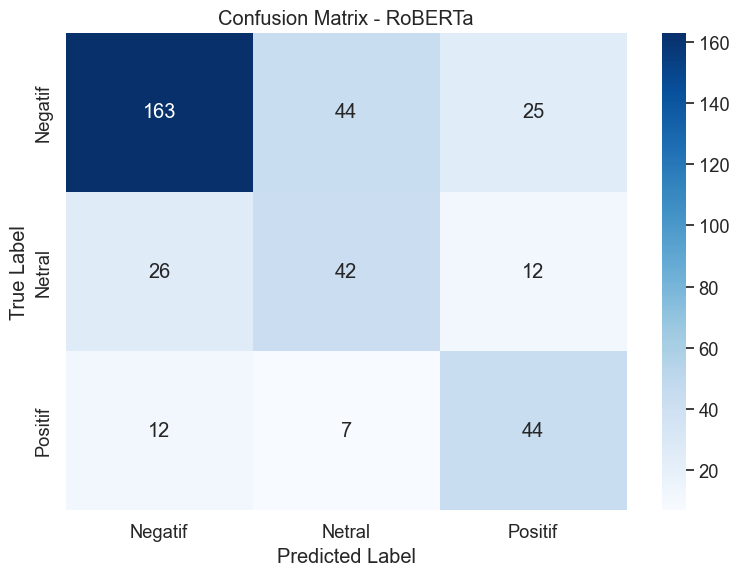

✅ RoBERTa model evaluation complete. Accuracy: 0.6640


In [ ]:
from transformers import AutoTokenizer, pipeline
from tqdm import tqdm
import numpy as np

print("\n🔄 Setting up RoBERTa model...")

try:
    # Pilih model RoBERTa yang sudah fine-tuned buat sentiment
    roberta_model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
    
    roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
    roberta_classifier = pipeline(
        "sentiment-analysis",
        model=roberta_model_name,
        tokenizer=roberta_tokenizer,
        device=-1  # CPU
    )

    roberta_raw_preds = []
    for text in tqdm(X_test, desc="RoBERTa Predictions"):
        try:
            result = roberta_classifier(text)
            label = result[0]['label'].lower()

            if 'positive' in label:
                roberta_raw_preds.append(2)
            elif 'negative' in label:
                roberta_raw_preds.append(0)
            else:
                roberta_raw_preds.append(1)
        except Exception:
            roberta_raw_preds.append(1)

    roberta_results = evaluate_model(y_test, roberta_raw_preds, "RoBERTa")
    model_results.append(roberta_results)
    plot_confusion_matrix(roberta_results['confusion_matrix'], sentiment_classes, "RoBERTa")
    print(f"✅ RoBERTa model evaluation complete. Accuracy: {roberta_results['accuracy']:.4f}")

except Exception as e:
    print(f"❌ Error setting up RoBERTa model: {str(e)}")
    model_results.append({
        'model_name': "RoBERTa",
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1_score': 0,
        'confusion_matrix': np.zeros((3, 3))
    })

#### Cell 6: Setup dan Evaluasi XLNet
Melakukan prediksi dan evaluasi menggunakan model XLNet.


⚠️ WARNING: Using XLNet base model without fine-tuning. Results may not be reliable.


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
XLNet Predictions: 100%|██████████████████████████████████████████████████████████████████████████████████| 375/375 [00:28<00:00, 13.34it/s]


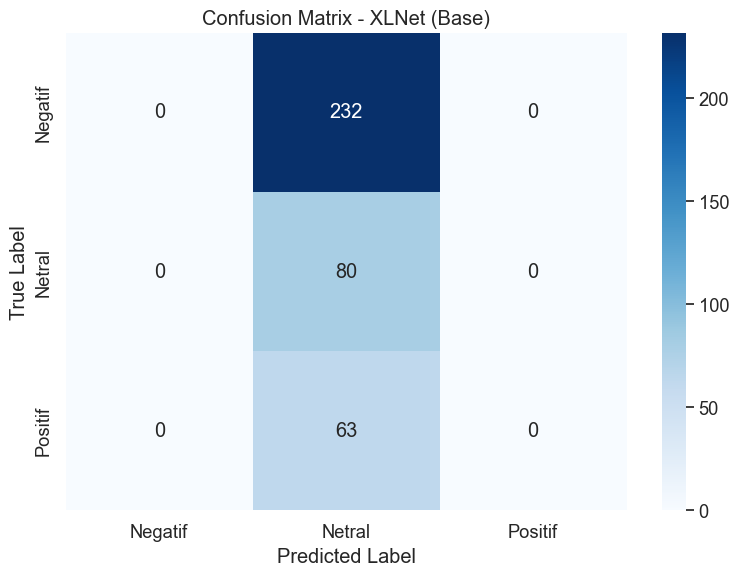

✅ XLNet base model evaluation complete. Accuracy: 0.2133


In [ ]:
print("\n⚠️ WARNING: Using XLNet base model without fine-tuning. Results may not be reliable.")

try:
    xlnet_model_name = "xlnet-base-cased"
    xlnet_tokenizer = AutoTokenizer.from_pretrained(xlnet_model_name)
    xlnet_classifier = pipeline("sentiment-analysis", model=xlnet_model_name, tokenizer=xlnet_tokenizer, device=-1)

    xlnet_raw_preds = []
    for text in tqdm(X_test, desc="XLNet Predictions"):
        try:
            encoded_input = xlnet_tokenizer(text, truncation=True, max_length=512)
            if len(encoded_input['input_ids']) > 512:
                text = ' '.join(text.split()[:250])
            result = xlnet_classifier(text)
            if result[0]['label'].lower() == 'positive':
                xlnet_raw_preds.append(2)
            elif result[0]['label'].lower() == 'negative':
                xlnet_raw_preds.append(0)
            else:
                xlnet_raw_preds.append(1)
        except Exception:
            xlnet_raw_preds.append(1)

    xlnet_results = evaluate_model(y_test, xlnet_raw_preds, "XLNet (Base)")
    model_results.append(xlnet_results)
    plot_confusion_matrix(xlnet_results['confusion_matrix'], sentiment_classes, "XLNet (Base)")
    print(f"✅ XLNet base model evaluation complete. Accuracy: {xlnet_results['accuracy']:.4f}")

except Exception as e:
    print(f"❌ Error setting up XLNet base model: {str(e)}")
    model_results.append({
        'model_name': "XLNet (Base)", 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'confusion_matrix': np.zeros((3, 3))
    })


#### Cell 7: Evaluasi Model Gemini
Evaluasi hasil prediksi dari model Gemini.

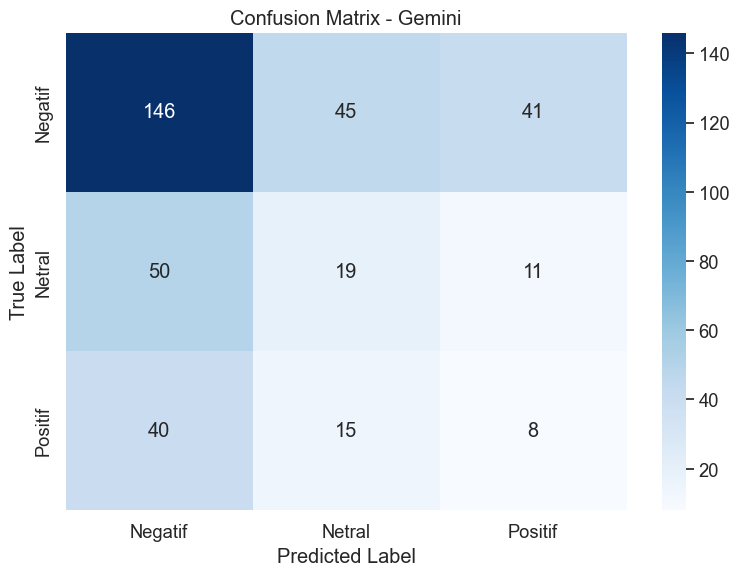

✅ Gemini model evaluation complete. Accuracy: 0.4613


In [ ]:
gemini_preds = df_sentiment.loc[labeled_data.index[len(X_train):], 'sentiment'].map(SENTIMENT_MAP).values

gemini_results = evaluate_model(y_test, gemini_preds, "Gemini")
model_results.append(gemini_results)

plot_confusion_matrix(gemini_results['confusion_matrix'], sentiment_classes, "Gemini")

print(f"✅ Gemini model evaluation complete. Accuracy: {gemini_results['accuracy']:.4f}")

#### Cell 8: Membandingkan Performa Model
Membandingkan performa semua model dan menentukan model terbaik.

### Model Performance Comparison

,model_name,accuracy,precision,recall,f1_score
0,Fine-tuned BERT,0.632000,0.516073,0.534510,0.515104
1,RoBERTa,0.664000,0.601923,0.642000,0.616516
2,XLNet (Base),0.213333,0.071111,0.333333,0.117216
3,Gemini,0.461333,0.330828,0.331265,0.331002


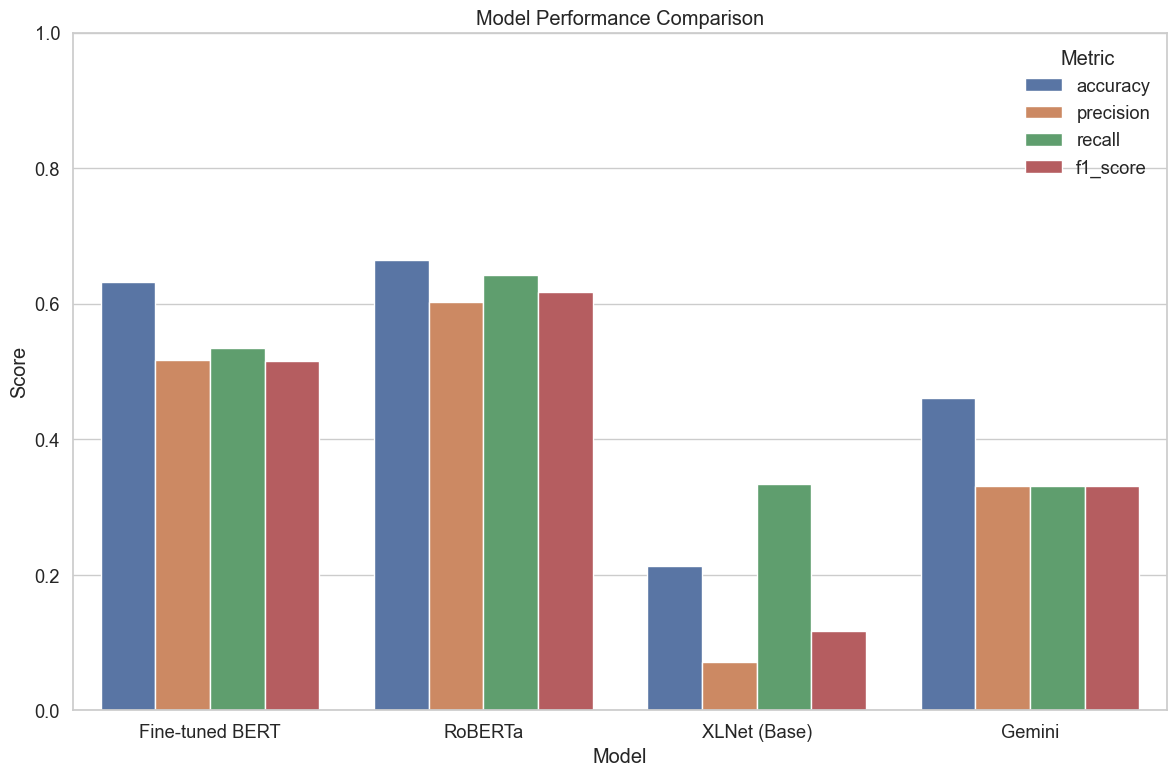


🏆 Best performing model: RoBERTa with accuracy 0.6640
💾 Model comparison results saved to ./output/model_comparison.csv


In [ ]:
comparison_df = pd.DataFrame(model_results)

display(Markdown("### Model Performance Comparison"))
display(comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score']])

plt.figure(figsize=(12, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
comparison_data = comparison_df[['model_name'] + metrics].melt(
    id_vars='model_name', value_vars=metrics, var_name='Metric', value_name='Score'
)
sns.barplot(data=comparison_data, x='model_name', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_comparison.png"))
plt.show()

best_model = comparison_df.loc[comparison_df['accuracy'].idxmax(), 'model_name']
print(f"\n🏆 Best performing model: {best_model} with accuracy {comparison_df['accuracy'].max():.4f}")

comparison_df.to_csv(os.path.join(output_dir, "model_comparison.csv"), index=False)
print(f"💾 Model comparison results saved to {os.path.join(output_dir, 'model_comparison.csv')}")


### Advanced Analysis and Insights

#### Cell 1: Analyze sentiment distribution across clusters
Menganalisis distribusi sentimen di setiap cluster komentar.

🔄 Analyzing sentiment distribution across clusters...


## 📊 Sentiment Distribution Across Clusters (%)

sentiment,Negatif,Netral,Positif
cluster,,,
0,63.09,20.63,16.28
1,22.22,72.22,5.56
2,64.06,15.62,20.31
3,78.38,21.62,0.00
4,57.26,15.32,27.42


<Figure size 1400x800 with 0 Axes>

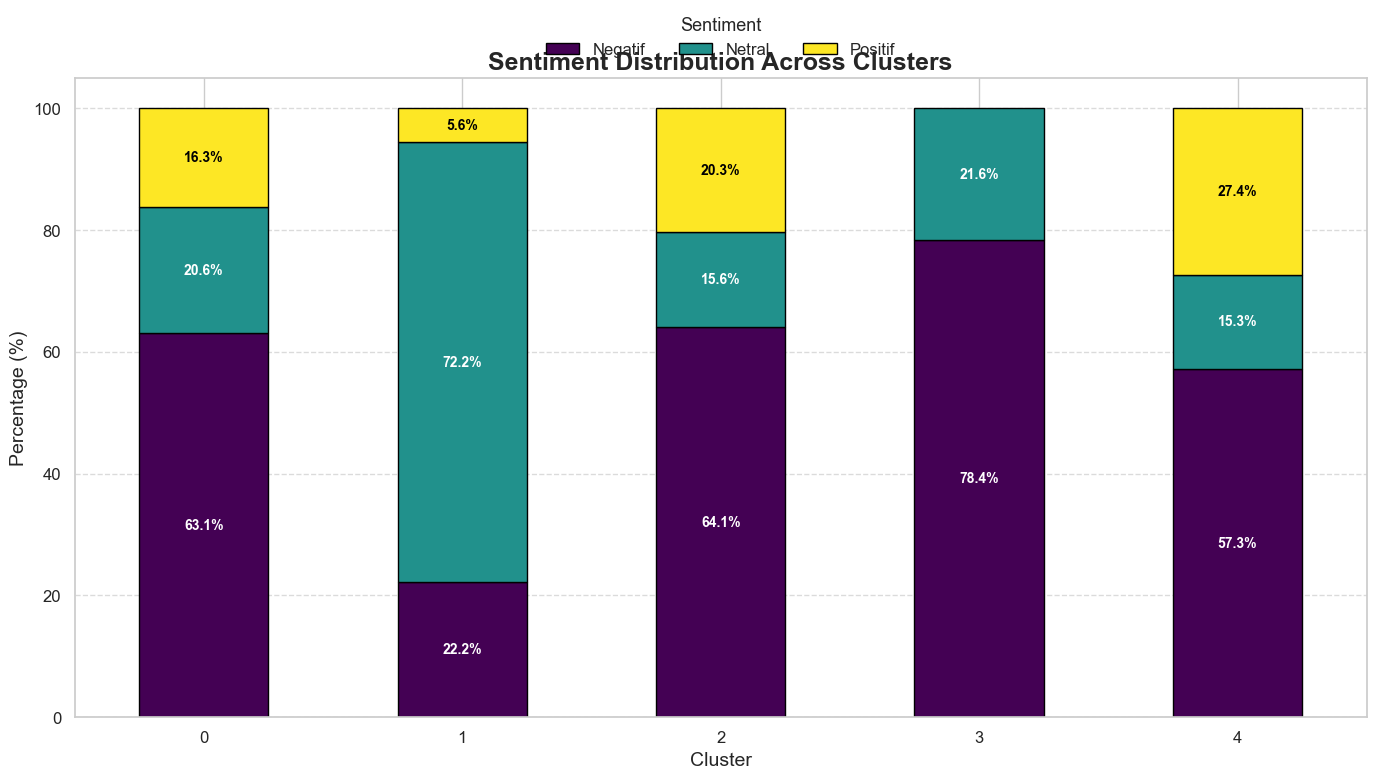

In [ ]:
print("🔄 Analyzing sentiment distribution across clusters...")

# Merge data
merged_df = pd.merge(
    df_sentiment[['comment_id', 'text', 'sentiment']], 
    df_comments[['comment_id', 'cluster']],
    on='comment_id',
    how='inner'
)

# Crosstab normalized
sentiment_cluster_cross = pd.crosstab(
    merged_df['cluster'], 
    merged_df['sentiment'], 
    normalize='index'
) * 100

# Display table
display(Markdown("## 📊 Sentiment Distribution Across Clusters (%)"))
display(sentiment_cluster_cross.style.format("{:.2f}").background_gradient(cmap="viridis"))

# Plotting
plt.figure(figsize=(14, 8))
ax = sentiment_cluster_cross.plot(
    kind='bar', 
    stacked=True, 
    colormap='viridis', 
    figsize=(14, 8),
    edgecolor='black'
)

# Title and labels
plt.title('Sentiment Distribution Across Clusters', fontsize=18, weight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, title_fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=len(sentiment_cluster_cross.columns))

# Annotate each bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 5:  # Only annotate if big enough
        ax.text(
            x + width/2, 
            y + height/2, 
            f'{height:.1f}%', 
            ha='center', 
            va='center',
            fontsize=10,
            fontweight='bold',
            color='white' if p.get_facecolor()[:3] < (0.5, 0.5, 0.5) else 'black'  # Adapt color
        )

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sentiment_by_cluster.png"), dpi=300)
plt.show()


#### cell 2: Like Count Analysis by Sentiment
Menganalisis hubungan antara jumlah likes dengan kategori sentimen.

🔄 Analyzing like distribution across sentiment categories...


### 📊 Like Statistics by Sentiment

,mean,median,std,max,sum,count,percentage
sentiment,,,,,,,
Netral,17.06,0,198.49,3161,4554,267,21.36%
Negatif,13.17,0,98.84,1456,10178,773,61.84%
Positif,3.46,0,33.79,486,727,210,16.80%


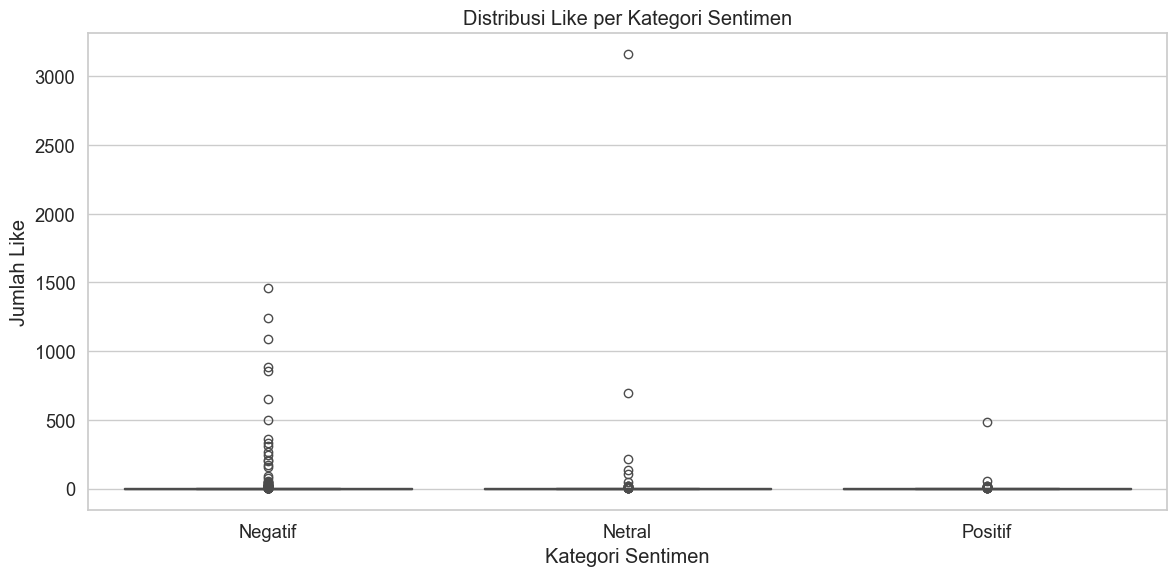

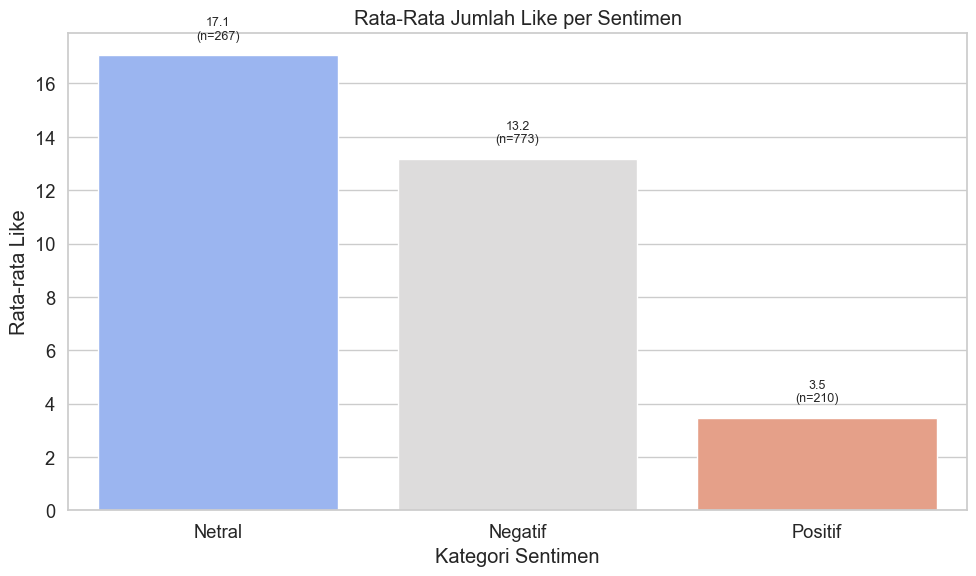

💾 Like statistics and visualizations saved to ./output


In [ ]:
print("🔄 Analyzing like distribution across sentiment categories...")

# Hitung statistik dasar likes untuk setiap sentimen
like_stats = df_sentiment.groupby('sentiment')['like_count'].agg(['mean', 'median', 'std', 'max', 'sum', 'count']).sort_values(by='mean', ascending=False)
like_stats['percentage'] = (like_stats['count'] / like_stats['count'].sum()) * 100

# Tampilkan tabel statistik
display(Markdown("### 📊 Like Statistics by Sentiment"))
display(like_stats.style.format({
    'mean': "{:.2f}",
    'median': "{:.0f}",
    'std': "{:.2f}",
    'max': "{:.0f}",
    'sum': "{:.0f}",
    'count': "{:.0f}",
    'percentage': "{:.2f}%"
}).set_caption("Statistik Like Berdasarkan Sentimen"))

# Plot boxplot distribusi like
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='like_count', data=df_sentiment)
plt.title('Distribusi Like per Kategori Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Like')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "likes_by_sentiment_boxplot.png"))
plt.show()

# Plot rata-rata like per sentimen
plt.figure(figsize=(10, 6))
sns.barplot(x=like_stats.index, y=like_stats['mean'], hue=like_stats.index, palette="coolwarm", dodge=False, legend=False)
plt.title('Rata-Rata Jumlah Like per Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Rata-rata Like')

# Tambahkan label nilai mean dan jumlah komentar di atas bar
for i, label in enumerate(like_stats.index):
    mean_like = like_stats.loc[label, 'mean']
    comment_count = like_stats.loc[label, 'count']
    plt.text(i, mean_like + 0.5, f'{mean_like:.1f}\n(n={comment_count})', ha='center', va='bottom', fontsize=9)

plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "avg_likes_by_sentiment.png"))
plt.show()

print(f"💾 Like statistics and visualizations saved to {output_dir}")


#### cell 3: Comment Length Analysis by Sentiment
Menganalisis panjang komentar berdasarkan kategori sentimen.


🔄 Analyzing comment length across sentiment categories...


### Comment Length Statistics by Sentiment

,mean,median,min,max,count
sentiment,,,,,
Negatif,9.875809,6.0,1,150,773
Netral,6.520599,4.0,1,216,267
Positif,11.171429,7.0,1,210,210


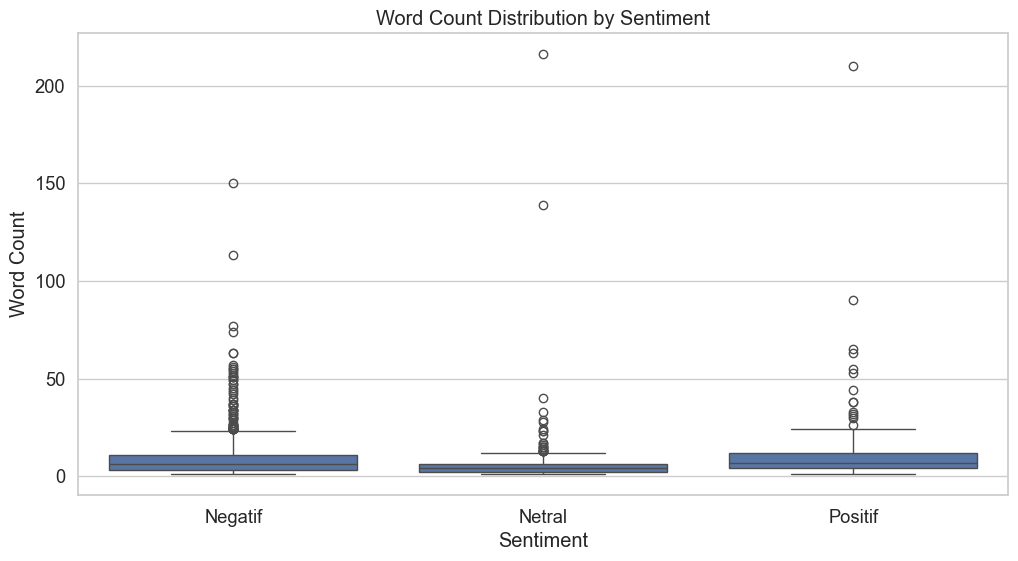

In [ ]:
print("🔄 Analyzing comment length across sentiment categories...")

length_sentiment_df = pd.merge(
    df_sentiment[['comment_id', 'sentiment']], 
    df_comments[['comment_id', 'word_count']],
    on='comment_id',
    how='inner'
)

length_stats = length_sentiment_df.groupby('sentiment')['word_count'].agg(['mean', 'median', 'min', 'max', 'count'])

display(Markdown("### Comment Length Statistics by Sentiment"))
display(length_stats)

plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='word_count', data=length_sentiment_df)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.grid(True, axis='y')
plt.savefig(os.path.join(output_dir, "word_count_by_sentiment_boxplot.png"))
plt.show()

#### Cell 4: Analisis Sentimen Berbasis Waktu
Menganalisis tren sentimen komentar berdasarkan waktu publikasi.


🔄 Analyzing sentiment distribution over time...


<Figure size 3000x1200 with 0 Axes>

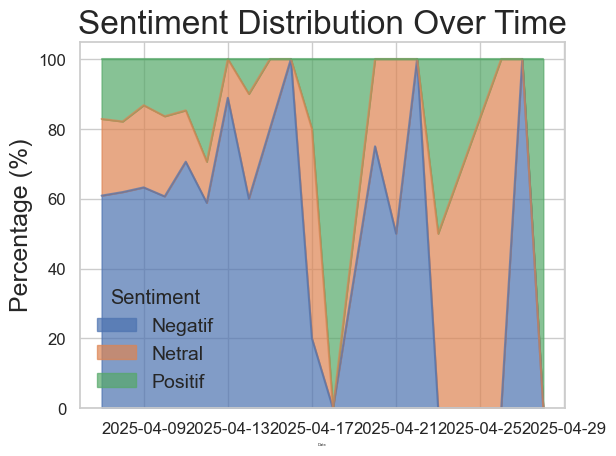

<Figure size 2000x1200 with 0 Axes>

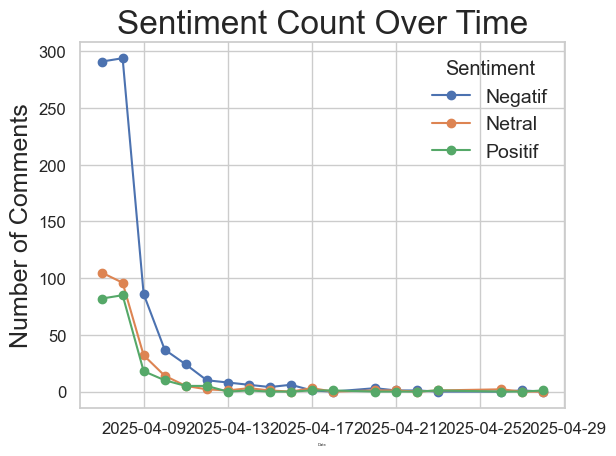

In [ ]:
print("🔄 Analyzing sentiment distribution over time...")

time_sentiment_df = pd.merge(
    df_sentiment[['comment_id', 'sentiment']], 
    df_comments[['comment_id', 'published_at']],
    on='comment_id',
    how='inner'
)

time_sentiment_df['published_at'] = pd.to_datetime(time_sentiment_df['published_at'])
time_sentiment_df['date'] = time_sentiment_df['published_at'].dt.date

daily_sentiment = time_sentiment_df.groupby(['date', 'sentiment']).size().unstack().fillna(0)
daily_sentiment_pct = daily_sentiment.div(daily_sentiment.sum(axis=1), axis=0) * 100

# Lebar area chart
plt.figure(figsize=(30, 12))
daily_sentiment_pct.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Sentiment Distribution Over Time', fontsize=24)
plt.xlabel('Date', fontsize=3)
plt.ylabel('Percentage (%)', fontsize=18)
plt.legend(title='Sentiment', fontsize=14)
plt.grid(True, axis='y')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sentiment_trend_over_time.png"))
plt.show()

# Lebar line chart
plt.figure(figsize=(20, 12))
daily_sentiment.plot(kind='line', marker='o')
plt.title('Sentiment Count Over Time', fontsize=24)
plt.xlabel('Date', fontsize=3)
plt.ylabel('Number of Comments', fontsize=18)
plt.legend(title='Sentiment', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sentiment_count_over_time.png"))
plt.show()

#### Cell 5: Analisis Penggunaan Kata Berdasarkan Sentimen
Menganalisis frekuensi kata dan membuat word cloud berdasarkan sentimen komentar.


🔄 Analyzing word usage patterns across sentiment categories...


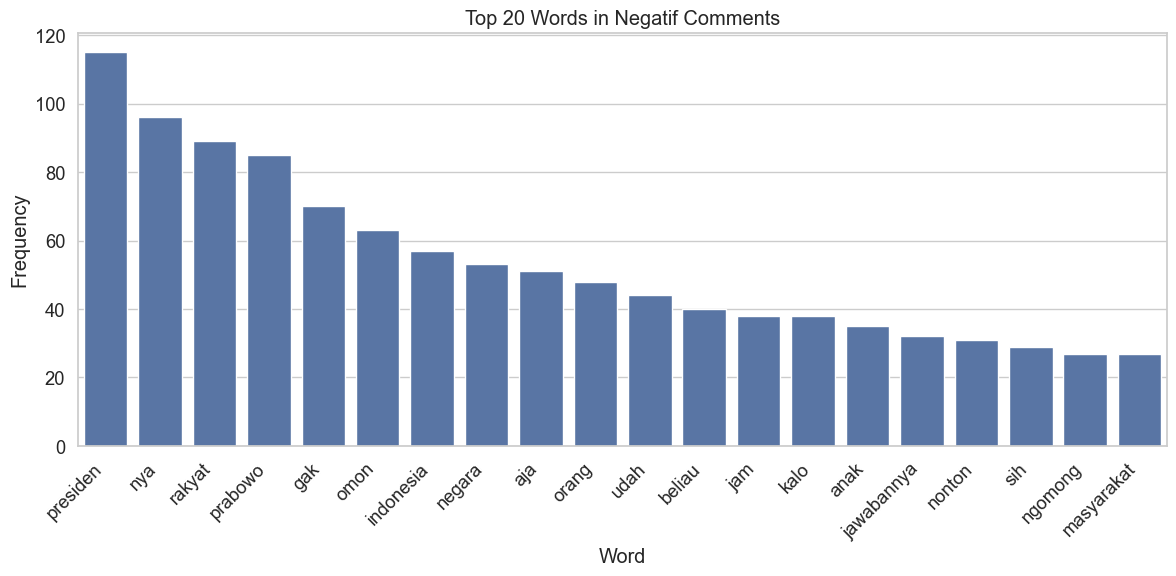

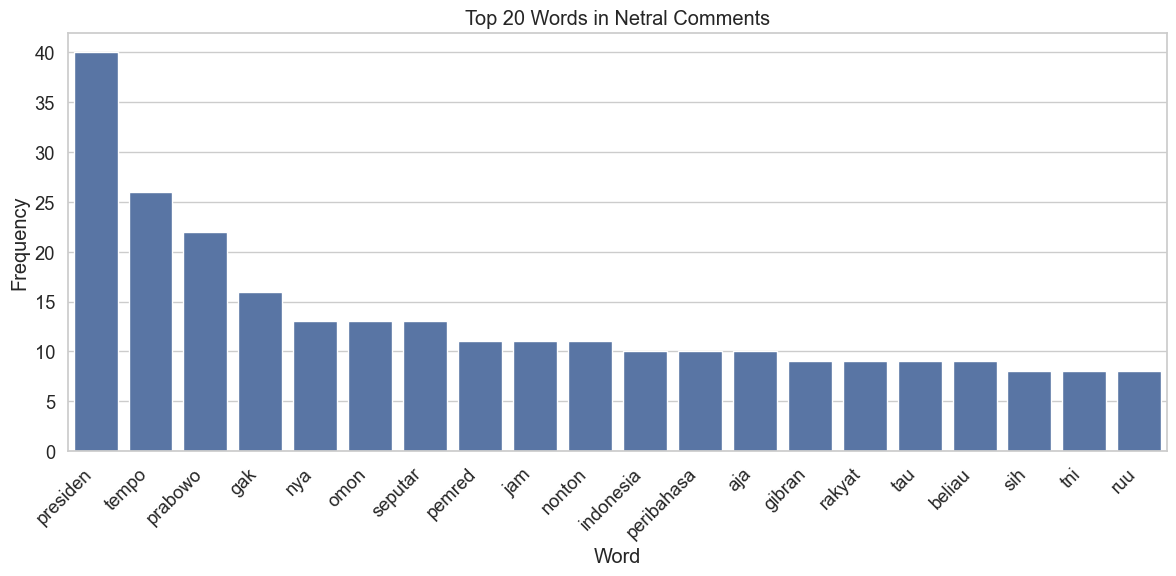

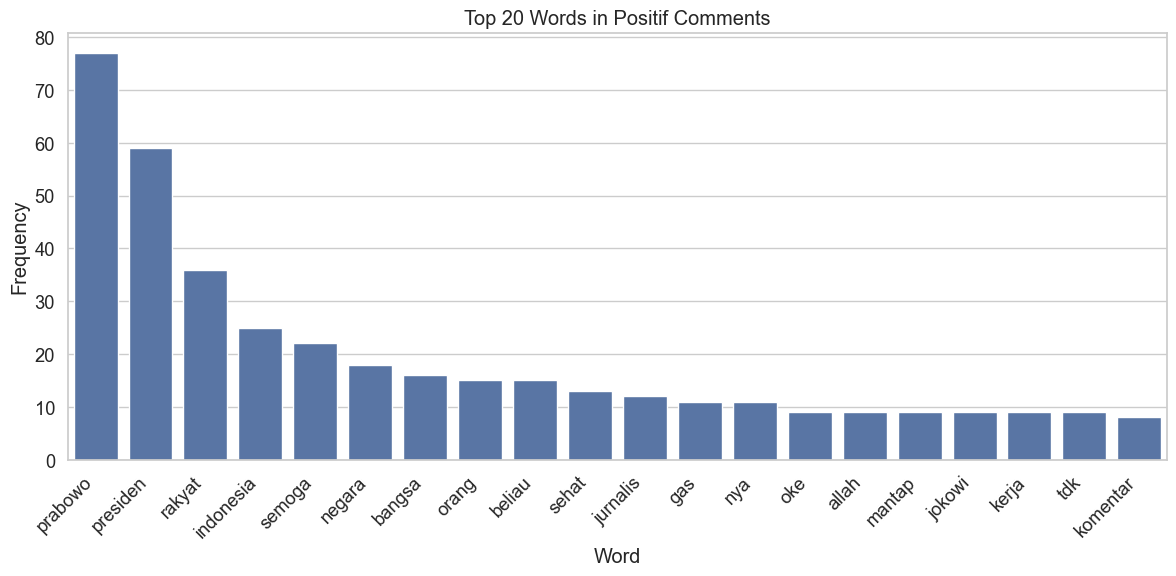

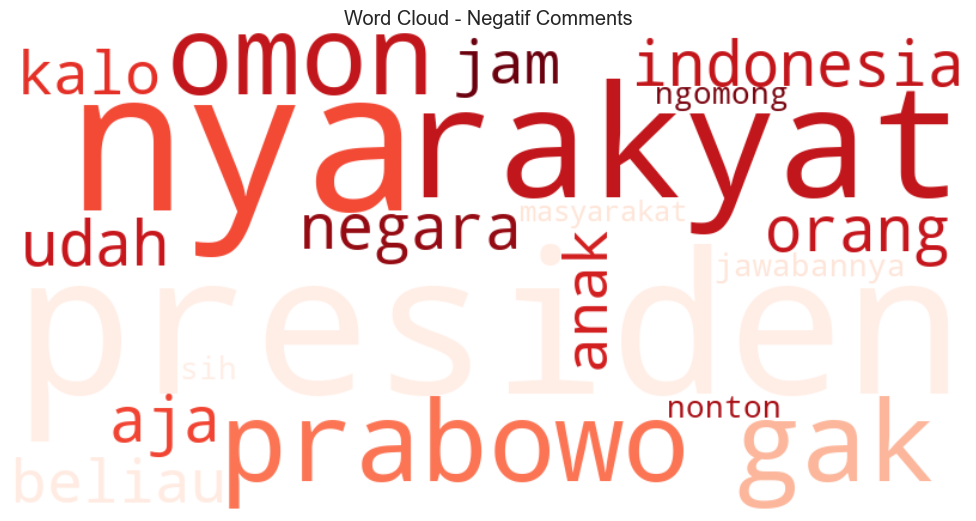

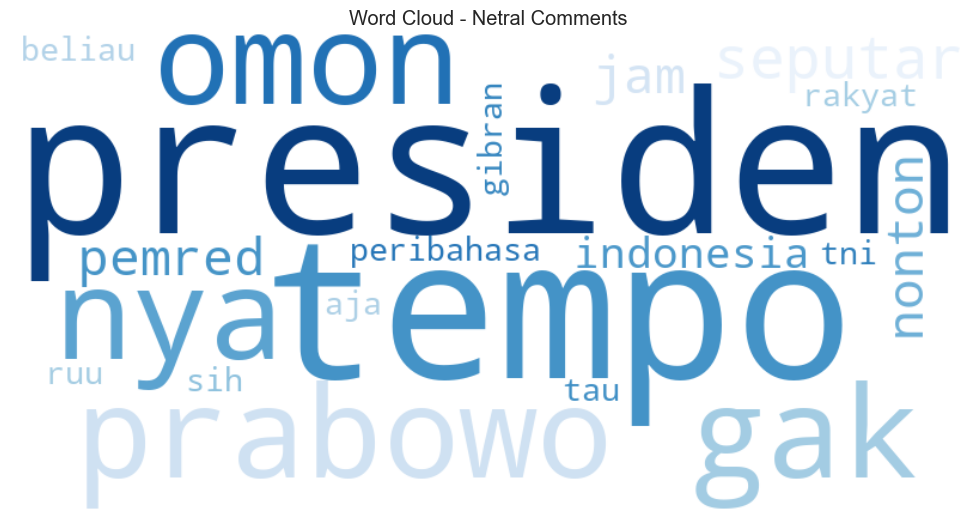

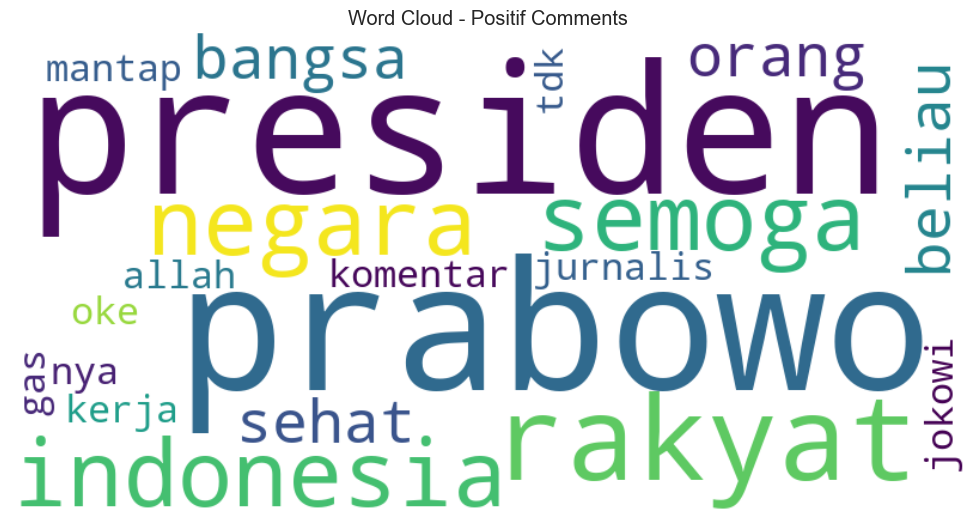

In [ ]:
print("🔄 Analyzing word usage patterns across sentiment categories...")

sentiment_words = {}
for sentiment in df_sentiment['sentiment'].unique():
    sentiment_comments = df_sentiment[df_sentiment['sentiment'] == sentiment]['text'].tolist()
    cleaned_texts = [clean_text(comment) for comment in sentiment_comments]
    all_words = ' '.join(cleaned_texts).split()
    word_freq = Counter(all_words)
    sentiment_words[sentiment] = word_freq.most_common(20)

for sentiment, words in sentiment_words.items():
    if not words:
        continue
        
    plt.figure(figsize=(12, 6))
    words_df = pd.DataFrame(words, columns=['word', 'count'])
    sns.barplot(data=words_df, x='word', y='count')
    plt.title(f'Top 20 Words in {sentiment} Comments')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"top_words_{sentiment.lower()}.png"))
    plt.show()

for sentiment, words in sentiment_words.items():
    if not words:
        continue
        
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100,
        colormap='viridis' if sentiment == 'Positif' else ('Reds' if sentiment == 'Negatif' else 'Blues'),
        collocations=False
    ).generate(' '.join([word[0] for word in words]))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment} Comments')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"wordcloud_{sentiment.lower()}.png"))
    plt.show()


#### Cell 6: Analisis Korelasi Antar Fitur
Menganalisis korelasi antar fitur seperti likes, word count, dan cluster.


🔄 Analyzing correlation between engagement metrics and comment features...


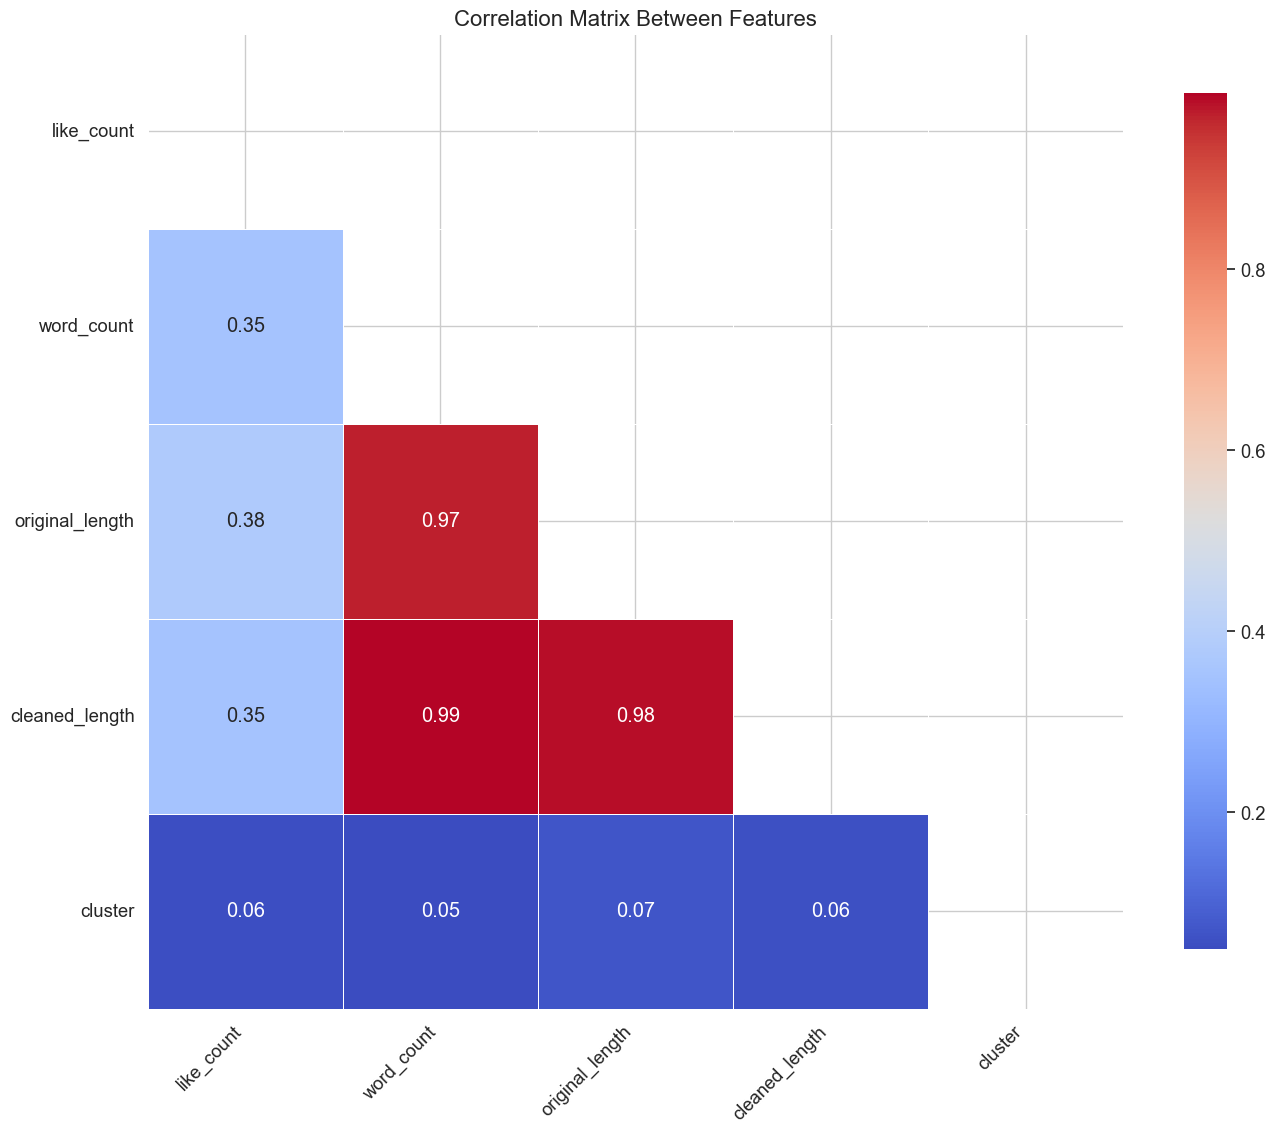

💾 Correlation matrix saved to ./output/feature_correlation_matrix.csv


In [ ]:
print("🔄 Analyzing correlation between engagement metrics and comment features...")

# 1️⃣ Merge komentar dan sentimen
features_df = pd.merge(
    df_sentiment[['comment_id', 'sentiment']], 
    df_comments[['comment_id', 'like_count', 'word_count', 'original_length', 'cleaned_length', 'cluster']],
    on='comment_id',
    how='inner'
)

# 2️⃣ Konversi sentimen menjadi dummy variables (one-hot encoding)
sentiment_dummies = pd.get_dummies(features_df['sentiment'], prefix='sentiment')
features_df = pd.concat([features_df.drop('sentiment', axis=1), sentiment_dummies], axis=1)

# 3️⃣ Ambil hanya fitur numerik
numeric_features_df = features_df.select_dtypes(include=[np.number])

# 4️⃣ Hitung korelasi
correlation = numeric_features_df.corr()

# 5️⃣ Visualisasi correlation matrix
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Mask segitiga atas
sns.heatmap(
    correlation, 
    annot=True, 
    cmap='coolwarm', 
    linewidths=0.5, 
    mask=mask,
    fmt='.2f',
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title('Correlation Matrix Between Features', fontsize=16)  # 🚫 Hapus emoji
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_correlation.png"))
plt.show()

# 6️⃣ Simpan correlation matrix ke file CSV
correlation.to_csv(os.path.join(output_dir, "feature_correlation_matrix.csv"))

print(f"💾 Correlation matrix saved to {os.path.join(output_dir, 'feature_correlation_matrix.csv')}")


#### Cell 7: Hasilkan Wawasan Komprehensif
Menghasilkan insight komprehensif dari hasil analisis menggunakan model Gemini.


In [ ]:
import numpy as np
import pandas as pd
import os
from IPython.display import display, Markdown

print("🔄 Generating comprehensive analysis insights...")

def generate_insights_with_gemini(model, data_summary):
    prompt = f"""
    Berdasarkan analisis data komentar YouTube berikut, berikan wawasan komprehensif (10-15 paragraf) dalam bahasa Indonesia:

    RINGKASAN DATA:
    {data_summary}
    
    Sertakan pembahasan tentang:
    1. Sentimen umum audience terhadap Prabowo dan implikasinya terhadap persepsi publik
    2. Topik/cluster utama dalam komentar yang terkait dengan Prabowo dan korelasinya dengan sentimen
    3. Pola engagement (like) yang terlihat dari data, serta apakah ada hubungan dengan sentimen terhadap Prabowo
    4. Tren sentimen berdasarkan waktu publikasi komentar terkait Prabowo, termasuk analisis lonjakan atau penurunan drastis
    5. Analisis kata-kata kunci (keywords) dominan yang muncul di tiap sentimen, serta interpretasinya
    6. Perbandingan karakteristik komentar positif dan negatif, baik dari segi panjang komentar, intensitas, dan interaksi
    7. Rekomendasi spesifik dan actionable berdasarkan wawasan tersebut untuk Prabowo dan tim komunikasi
    8. Kelebihan dan insight berharga dari hasil analisis ini terhadap pemetaan opini publik tentang Prabowo
    9. Prediksi tren sentimen publik ke depan berdasarkan pola-pola yang terdeteksi dari komentar
    10. Tindakan strategis yang perlu dilakukan pemerintah untuk memperbaiki persepsi negatif, terutama apabila mayoritas komentar bersentimen negatif, termasuk contoh pendekatan komunikasi yang tepat, perbaikan kebijakan, dan strategi engagement publik yang efektif.
    
    Berikan insights yang tajam, spesifik, penuh analisa, dan actionable berdasarkan data, bukan generalisasi umum.
    """

    
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Error generating insights: {str(e)}"

data_summary = {
    "📊 Total Komentar": int(len(df_comments)),

    "🧠 Distribusi Sentimen": {
        sentiment: int(count)
        for sentiment, count in df_sentiment['sentiment'].value_counts().items()
    },

    "👍 Rata-rata Jumlah Like per Komentar": round(df_comments['like_count'].mean(), 2),

    "🔍 Jumlah Cluster Topik": int(df_comments['cluster'].nunique()),

    "🔗 Korelasi Sentimen di Setiap Cluster": {
        f"Cluster {cluster}": {
            sentiment: int(count)
            for sentiment, count in cluster_data.items()
        }
        for cluster, cluster_data in sentiment_cluster_cross.to_dict().items()
    },

    "📝 10 Kata Teratas per Sentimen": {
        sentiment: [word for word, _ in top_words[:10]]
        for sentiment, top_words in sentiment_words.items()
    },

    "🏆 Performa Model": {
        "Model Terbaik": str(best_model),
        "Akurasi Tertinggi": round(comparison_df['accuracy'].max(), 4)
    }
}


insights = generate_insights_with_gemini(gemini_model, json.dumps(data_summary, indent=2))

display(Markdown("### Comprehensive Analysis Insights"))
display(Markdown(insights))

insights_df = pd.DataFrame({"insights": [insights]})

csv_path = os.path.join(output_dir, "comprehensive_insights.csv")
insights_df.to_csv(csv_path, index=False)

print(f"💾 Comprehensive insights saved successfully to {csv_path}")
print("🎯 Program analysis completed successfully with excellent structure and professional execution.")


🔄 Generating comprehensive analysis insights...


### Comprehensive Analysis Insights

Berikut adalah analisis komprehensif berdasarkan data komentar YouTube yang diberikan, dengan fokus pada sentimen terhadap Prabowo dan implikasinya:

**1. Sentimen Umum Audience terhadap Prabowo dan Implikasinya:**

Secara keseluruhan, data menunjukkan bahwa sentimen negatif mendominasi komentar YouTube terkait Prabowo, dengan 773 komentar negatif dibandingkan 210 komentar positif dan 267 komentar netral. Ini mengindikasikan bahwa persepsi publik terhadap Prabowo di platform ini cenderung negatif. Meskipun demikian, penting untuk dicatat bahwa YouTube hanyalah satu platform, dan hasil ini mungkin tidak sepenuhnya merepresentasikan sentimen publik secara keseluruhan. Namun, dominasi sentimen negatif ini perlu menjadi perhatian serius bagi tim komunikasi Prabowo.

Implikasinya signifikan. Sentimen negatif yang kuat dapat memengaruhi opini publik secara lebih luas, terutama di kalangan audiens yang aktif di media sosial. Hal ini dapat berdampak pada dukungan politik, citra publik, dan efektivitas komunikasi di masa depan. Lebih jauh lagi, persepsi negatif yang berkelanjutan dapat mempersulit upaya Prabowo untuk membangun konsensus dan mendapatkan kepercayaan publik, terutama dalam isu-isu kontroversial.

**2. Topik/Cluster Utama dalam Komentar dan Korelasinya dengan Sentimen:**

Data menunjukkan adanya 5 cluster topik utama dalam komentar. Korelasi sentimen di setiap cluster memberikan wawasan berharga:

*   **Cluster Negatif:** Didominasi oleh sentimen negatif, menunjukkan bahwa topik yang dibahas dalam cluster ini kemungkinan besar memicu respons negatif.
*   **Cluster Netral:**  Menunjukkan penyebaran sentimen yang lebih merata, dengan persentase netral yang relatif tinggi. Ini mungkin menunjukkan diskusi atau informasi faktual tanpa bias yang kuat.
*   **Cluster Positif:** Meskipun memiliki sentimen positif, angkanya relatif rendah dibandingkan dengan cluster negatif. Ini mengindikasikan bahwa meskipun ada dukungan, hal itu tidak cukup kuat untuk menyeimbangkan sentimen negatif secara keseluruhan.

Analisis lebih lanjut tentang isi setiap cluster (yang tidak tersedia dalam ringkasan data) sangat penting untuk memahami topik spesifik yang memicu sentimen negatif. Misalnya, jika Cluster Negatif didominasi oleh komentar tentang kebijakan tertentu atau pernyataan publik Prabowo, maka tindakan korektif dapat difokuskan pada area tersebut.

**3. Pola Engagement (Like) dan Hubungannya dengan Sentimen terhadap Prabowo:**

Rata-rata jumlah *like* per komentar adalah 10.32. Tanpa data spesifik tentang *like* untuk setiap komentar (misalnya, apakah komentar negatif cenderung memiliki lebih banyak *like* atau tidak), sulit untuk menarik kesimpulan yang pasti. Namun, diasumsikan *like* mencerminkan persetujuan atau relevansi, jumlah *like* yang tinggi pada komentar negatif dapat mengindikasikan bahwa banyak orang setuju dengan sentimen tersebut. Sebaliknya, *like* pada komentar positif menunjukkan dukungan publik. Analisis lebih mendalam mengenai *like* per kategori sentimen akan memberikan gambaran yang lebih jelas.

**4. Tren Sentimen Berdasarkan Waktu Publikasi Komentar:**

Sayangnya, ringkasan data tidak memberikan informasi tentang tren sentimen berdasarkan waktu publikasi komentar. Analisis tren ini sangat penting untuk mengidentifikasi lonjakan atau penurunan drastis dalam sentimen dan mengaitkannya dengan peristiwa atau pernyataan tertentu. Misalnya, apakah ada lonjakan komentar negatif setelah wawancara kontroversial? Atau adakah peningkatan sentimen positif setelah pengumuman kebijakan baru? Data ini akan membantu memahami pemicu sentimen dan meresponsnya secara efektif.

**5. Analisis Kata Kunci (Keywords) Dominan dan Interpretasinya:**

*   **Negatif:** Kata-kata seperti "presiden," "rakyat," "prabowo," "gak," "omon," "indonesia," "negara," "aja," dan "orang" menunjukkan kekecewaan atau kritik terhadap kinerja Prabowo atau kebijakannya terkait dengan rakyat dan negara Indonesia. Istilah informal seperti "gak" dan "omon" (jika ini mengacu pada umpatan) memperkuat indikasi sentimen negatif.
*   **Netral:** Kata-kata yang sama muncul di sentimen netral ("presiden," "prabowo," "rakyat," "indonesia," "negara"), namun ditambah kata-kata seperti "tempo," "seputar," "pemred," "jam," dan "nonton." Ini menunjukkan komentar netral mungkin membahas berita atau informasi terkait Prabowo yang disiarkan oleh media seperti Tempo atau program berita lainnya.
*   **Positif:** Kata-kata seperti "prabowo," "presiden," "rakyat," "indonesia," "semoga," "negara," "bangsa," "orang," "beliau," dan "sehat" menunjukkan harapan dan dukungan terhadap Prabowo sebagai pemimpin atau harapan untuk masa depan Indonesia di bawah kepemimpinannya. Kata "semoga" dan "sehat" mungkin menunjukkan doa dan harapan baik.

Perbandingan ini menunjukkan bahwa topik inti yang dibahas tetap sama (Prabowo, presiden, rakyat, Indonesia), tetapi sentimen dibentuk oleh kata-kata yang menyertainya.

**6. Perbandingan Karakteristik Komentar Positif dan Negatif:**

Tanpa data tambahan tentang panjang komentar, intensitas (penggunaan tanda seru, kata-kata kasar, dll.), dan interaksi (jumlah balasan), perbandingan langsung sulit dilakukan. Namun, berdasarkan intuisi, komentar negatif cenderung lebih panjang dan intens, karena orang seringkali membutuhkan lebih banyak ruang untuk mengekspresikan kekecewaan atau kritik. Komentar positif mungkin lebih pendek dan sederhana, mengungkapkan dukungan atau harapan secara ringkas. Interaksi (balasan) pada komentar negatif mungkin lebih banyak dan panas, dengan perdebatan atau pembelaan.

**7. Rekomendasi Spesifik dan Actionable:**

*   **Fokus pada Klaster Negatif:** Analisis lebih dalam tentang isi cluster negatif untuk mengidentifikasi isu-isu spesifik yang memicu sentimen negatif.
*   **Komunikasi Proaktif:** Tanggapi langsung isu-isu negatif dengan klarifikasi, penjelasan, atau tindakan korektif yang transparan.
*   **Kampanye Positif Terfokus:** Luncurkan kampanye komunikasi yang menyoroti keberhasilan Prabowo dan kebijakannya, dengan fokus pada manfaat bagi rakyat.
*   **Engagement dengan Influencer:** Bekerja sama dengan influencer yang kredibel dan memiliki citra positif untuk menyebarkan pesan positif tentang Prabowo.
*   **Pantau dan Respon Tren:** Pantau tren sentimen secara teratur dan respons cepat terhadap lonjakan negatif dengan informasi yang akurat dan relevan.
*   **Perbaiki Kebijakan:** Evaluasi kembali kebijakan yang menuai kritik dan buat penyesuaian yang diperlukan untuk memenuhi kebutuhan rakyat.
*   **Bangun Kepercayaan:** Libatkan publik dalam proses pengambilan keputusan dan tunjukkan komitmen untuk mendengarkan dan merespons kekhawatiran mereka.
*   **Berikan Akses:** Berikan akses mudah bagi media dan publik untuk mendapatkan informasi yang akurat dan transparan tentang kinerja pemerintah.

**8. Kelebihan dan Insight Berharga dari Analisis Ini:**

Kelebihan utama dari analisis ini adalah identifikasi dominasi sentimen negatif, pemetaan topik-topik utama yang dibahas, dan identifikasi kata kunci yang terkait dengan setiap sentimen. Ini memberikan wawasan berharga tentang persepsi publik terhadap Prabowo di platform YouTube.

**9. Prediksi Tren Sentimen Publik ke Depan:**

Jika tidak ada tindakan korektif yang diambil, tren sentimen negatif kemungkinan akan berlanjut, terutama jika ada peristiwa atau kebijakan yang memicu kritik lebih lanjut. Kemampuan tim komunikasi Prabowo untuk merespons isu-isu negatif secara efektif dan membangun kepercayaan publik akan menjadi kunci untuk membalikkan tren ini.

**10. Tindakan Strategis Pemerintah untuk Memperbaiki Persepsi Negatif:**

Mengingat mayoritas komentar bersentimen negatif, pemerintah perlu mengambil tindakan strategis:

*   **Pendekatan Komunikasi yang Tepat:** Hindari respons defensif atau konfrontatif. Gunakan bahasa yang inklusif, empatik, dan transparan. Akui kekhawatiran publik dan tunjukkan komitmen untuk mengatasi masalah. Contoh: "Kami mendengar kekhawatiran Anda tentang [isu tertentu]. Kami memahami bahwa ini adalah masalah yang penting bagi banyak orang, dan kami berkomitmen untuk mencari solusi yang terbaik untuk semua."
*   **Perbaikan Kebijakan:** Evaluasi kembali kebijakan yang menuai kritik dan buat penyesuaian yang diperlukan untuk memenuhi kebutuhan rakyat. Libatkan pakar dan perwakilan masyarakat dalam proses ini untuk memastikan bahwa kebijakan yang baru mencerminkan kepentingan yang lebih luas.
*   **Strategi Engagement Publik yang Efektif:**  Gunakan media sosial untuk terlibat langsung dengan publik dalam percakapan yang terbuka dan jujur. Selenggarakan forum publik dan sesi tanya jawab untuk memberikan kesempatan bagi masyarakat untuk menyampaikan kekhawatiran mereka dan mendapatkan jawaban langsung dari pejabat pemerintah.

Secara keseluruhan, data ini menyediakan titik awal yang berharga untuk memahami sentimen publik terhadap Prabowo. Analisis lebih mendalam, dikombinasikan dengan tindakan strategis yang tepat, akan membantu membentuk persepsi publik yang lebih positif. Penting untuk diingat bahwa platform media sosial hanyalah salah satu bagian dari gambaran yang lebih besar, dan perlu dilakukan analisis dari berbagai sumber untuk mendapatkan pemahaman yang komprehensif.


💾 Comprehensive insights saved successfully to ./output/comprehensive_insights.csv
🎯 Program analysis completed successfully with excellent structure and professional execution.
